<a href="https://colab.research.google.com/github/batu-el/l65_be301_dc755/blob/main/L65_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# L65 Project - An Attempt at Mechanistic Interpretability of Graph Neural Networks

## Introduction



## Contents


The **aims** of this project are as follows:

1. Mechanistic interpretability has been used to interpret trnansformers. it requires a detailed analysis of the activations at each layer of the model. however, currently, there is no library that provides a way to capture and analyze the activations of GNNs conveniently. That is why we present GNNLens. For our project, we implement x models as a start, but we are planning to build on this library which we think lays the groundwork for the mechanistic interpretability of GNNs in the future.

2. Our initial intuition on Message passing / attention in GNNs was that they may be able to recover the graph sturucture in the case of dense (fully connected) GNNs. We ran a series of experiements to check this intuition. We find that ....


3. SVD on activations has been applied in this neel nanda paper. and it stongly echoes the finding of the GCexplainer where k means clustering is used to recover concepts from the lasy message passing layer of the network. The intuition here is not all the activations are interpretable becuase there is some randomness in the model. however, the principal components principle components can be meaningful.

4. Running the model multiple times and seeing which of the values in the attention matrix ends up taking high values consistently is a principled way to know which nodes are attending to each other. This is especially important because we observe that there is significant randomness in the learned attention matrices across different runs.

## Outline

This practical is split into 2 parts:

**Part 1:** GCN

**Part 2:** GAT

**Part 3:** MPNN


# ⚙️ [Setup] Installation and Setup

**❗️Note:** You will need a GPU to complete this practical. Remember to click `Runtime -> Change runtime type`, and set the `hardware accelerator` to **GPU**.

In [1]:
#@title [RUN] Sanity check torch version and GPU runtime

import torch
assert torch.cuda.is_available(), "WARNING! You are running on a non-GPU instance. For this practical a GPU is highly recommended."
REQUIRED_VERSION = "2.1.0+cu121"
TORCH_VERSION = torch.__version__
CUDA_VERSION = TORCH_VERSION.split("+")

if TORCH_VERSION != REQUIRED_VERSION:
  print(f"Detected torch version {TORCH_VERSION}, but notebook was created for {REQUIRED_VERSION}")
  print(f"Attempting installation of {REQUIRED_VERSION}")
  !pip install torch==2.1.0+cu121
print("Correct version of torch detected. You are running on a machine with GPU.")


Correct version of torch detected. You are running on a machine with GPU.


In [2]:
#@title [RUN] Install required python libraries
import os

# Install PyTorch Geometric and other libraries
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Installing PyTorch Geometric")
    !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
    !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
    !pip install -q torch-geometric
    print("Installing other libraries")
    !pip install -q rdkit-pypi==2021.9.4
    !pip install -q py3Dmol==1.8.0
    !pip install networkx
    !pip install mycolorpy
    !pip install colorama

Installing PyTorch Geometric
Installing other libraries


In [3]:
#@title [RUN] Import python modules

import os
import sys
import time
import math
import random
import itertools
from datetime import datetime
from typing import Mapping, Tuple, Sequence, List

import pandas as pd
import networkx as nx
import numpy as np
import scipy as sp
from scipy.stats import ortho_group
from scipy.linalg import block_diag

import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import Embedding, Linear, ReLU, BatchNorm1d, Module, ModuleList, Sequential

import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.datasets import Planetoid, QM9
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_scatter import scatter, scatter_mean, scatter_max, scatter_sum

import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

import py3Dmol
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns
from mycolorpy import colorlist as mcp
import matplotlib.cm as cm
import colorama

from google.colab import files
from IPython.display import HTML

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

print("All imports succeeded.")
print("Python version {}".format(sys.version))
print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

All imports succeeded.
Python version 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch version 2.1.0+cu121
PyG version 2.5.1


In [4]:
#@title [RUN] Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)
print("All seeds set.")

All seeds set.


In [5]:
#@title [RUN] Helper functions for data preparation

class SetTarget:
    """
    This transform modifies the labels vector per data sample to only keep
    the label for a specific target (there are 19 targets in QM9).

    Note: for this practical, we have hardcoded the target to be target #0,
    i.e. the electric dipole moment of a drug-like molecule.
    (https://en.wikipedia.org/wiki/Electric_dipole_moment)
    """
    def __call__(self, data):
        target = 0 # we hardcoded choice of target
        data.y = data.y[:, target]
        return data


class CompleteGraph:
    """
    This transform adds all pairwise edges into the edge index per data sample,
    then removes self loops, i.e. it builds a fully connected or complete graph
    """
    def __call__(self, input):
        data = input.clone()
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim=0)

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data

print("Helper functions loaded.")

Helper functions loaded.


In [6]:
# @title [RUN] Helper functions for plots and visualisations


def draw_one_graph(ax, edges, label=None, node_emb=None, layout=None, special_color=False):
    """draw a graph with networkx based on adjacency matrix (edges)
    graph labels could be displayed as a title for each graph
    node_emb could be displayed in colors
    """
    graph = nx.Graph()
    edges = zip(edges[0], edges[1])
    graph.add_edges_from(edges)
    node_pos = layout(graph)
    #add colors according to node embeding
    if (node_emb is not None) or special_color:
        color_map = []
        node_list = [node[0] for node in graph.nodes(data = True)]
        for i,node in enumerate(node_list):
            #just ignore this branch
            if special_color:
                if len(node_list) == 3:
                    crt_color = (1,0,0)
                elif len(node_list) == 5:
                    crt_color = (0,1,0)
                elif len(node_list) == 4:
                    crt_color = (1,1,0)
                else:
                  special_list = [(1,0,0)] * 3 + [(0,1,0)] * 5 + [(1,1,0)] * 4
                  crt_color = special_list[i]
            else:
                crt_node_emb = node_emb[node]
                #map float number (node embeding) to a color
                crt_color = cm.gist_rainbow(crt_node_emb, bytes=True)
                crt_color = (crt_color[0]/255.0, crt_color[1]/255.0, crt_color[2]/255.0, crt_color[3]/255.0)
            color_map.append(crt_color)

        nx.draw_networkx_nodes(graph,node_pos, node_color=color_map,
                        nodelist = node_list, ax=ax)
        nx.draw_networkx_edges(graph, node_pos, ax=ax)
        nx.draw_networkx_labels(graph,node_pos, ax=ax)
    else:
        nx.draw_networkx(graph, node_pos, ax=ax)


def gallery(graphs, labels=None, node_emb=None, special_color=False, max_graphs=4, max_fig_size=(40, 10), layout=nx.layout.kamada_kawai_layout):
    ''' Draw multiple graphs as a gallery
    Args:
      graphs: torch_geometrics.dataset object/ List of Graph objects
      labels: num_graphs
      node_emb: num_graphs* [num_nodes x num_ch]
      max_graphs: maximum graphs display
    '''
    num_graphs = min(len(graphs), max_graphs)
    ff, axes = plt.subplots(1, num_graphs,
                            figsize=max_fig_size,
                            subplot_kw={'xticks': [], 'yticks': []})
    if num_graphs == 1:
        axes = [axes]
    if node_emb is None:
        node_emb = num_graphs*[None]
    if labels is None:
        labels = num_graphs * [" "]


    for i in range(num_graphs):
        draw_one_graph(axes[i], graphs[i].edge_index.numpy(), labels[i], node_emb[i], layout, special_color)
        if labels[i] != " ":
            axes[i].set_title(f"Target: {labels[i]}", fontsize=28)
        axes[i].set_axis_off()
    plt.show()


def hash_node_embedings(node_emb):
  """ Hash the tensor representing nodes' features
  to a number in [0,1] used to represent a color

  Args:
    node_emb: list of num_graphs arrays, each of dim (num_nodes x num_feats)
  Returns:
    list of num_graphs arrays in [0,1], each of dim (num_nodes)
  """
  chunk_size_graph = [x.shape[0] for x in node_emb]
  start_idx_graph = [0] + list(itertools.accumulate(chunk_size_graph))[:-1]

  node_emb_flatten = np.concatenate(node_emb).mean(-1)

  min_emb = node_emb_flatten.min()
  max_emb = node_emb_flatten.max()
  node_emb_flatten = (node_emb_flatten-min_emb)/(max_emb-min_emb)

  #split in graphs again according to (start_idx_graph, chunk_size_graph)
  node_emb_hashed = [node_emb_flatten[i:i+l] for (i,l) in zip(start_idx_graph, chunk_size_graph)]
  return node_emb_hashed


def update_stats(training_stats, epoch_stats):
    """ Store metrics along the training
    Args:
      epoch_stats: dict containg metrics about one epoch
      training_stats: dict containing lists of metrics along training
    Returns:
      updated training_stats
    """
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key,val in epoch_stats.items():
        training_stats[key].append(val)
    return training_stats


def plot_stats(training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    stats_names = [key[6:] for key in training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            training_stats['epoch'],
            training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            training_stats['epoch'],
            training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)


def get_color_coded_str(i, color):
    return "\033[3{}m{}\033[0m".format(int(color), int(i))


def print_color_numpy(map, list_graphs):
    """ print matrix map in color according to list_graphs
    """
    list_blocks = []
    for i,graph in enumerate(list_graphs):
        block_i = (i+1)*np.ones((graph.num_nodes,graph.num_nodes))
        list_blocks += [block_i]
    block_color = block_diag(*list_blocks)

    map_modified = np.vectorize(get_color_coded_str)(map, block_color)
    print("\n".join([" ".join(["{}"]*map.shape[0])]*map.shape[1]).format(*[x for y in map_modified.tolist() for x in y]))


#############################################
# Visualization helpers for molecular graphs
#############################################

allowable_atoms = [
    "H",
    "C",
    "N",
    "O",
    "F",
    "C",
    "Cl",
    "Br",
    "I",
    "H",
    "Unknown",
]

def to_atom(t):
    try:
        return allowable_atoms[int(t.argmax())]
    except:
        return "C"


def to_bond_index(t):
    t_s = t.squeeze()
    return [1, 2, 3, 4][
        int(
            torch.dot(
                t_s,
                torch.tensor(
                    range(t_s.size()[0]), dtype=torch.float, device=t.device
                ),
            ).item()
        )
    ]

def to_rdkit(data, device=None):
    has_pos = False
    node_list = []
    for i in range(data.x.size()[0]):
        node_list.append(to_atom(data.x[i][:5]))

    # create empty editable mol object
    mol = Chem.RWMol()
    # add atoms to mol and keep track of index
    node_to_idx = {}
    invalid_idx = set([])
    for i in range(len(node_list)):
        if node_list[i] == "Stop" or node_list[i] == "H":
            invalid_idx.add(i)
            continue
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    added_bonds = set([])
    for i in range(0, data.edge_index.size()[1]):
        ix = data.edge_index[0][i].item()
        iy = data.edge_index[1][i].item()
        bond = to_bond_index(data.edge_attr[i])  # <font color='red'>TODO</font> fix this
        # bond = 1
        # add bonds between adjacent atoms

        if data.edge_attr[i].sum() == 0:
          continue

        if (
            (str((ix, iy)) in added_bonds)
            or (str((iy, ix)) in added_bonds)
            or (iy in invalid_idx or ix in invalid_idx)
        ):
            continue
        # add relevant bond type (there are many more of these)

        if bond == 0:
            continue
        elif bond == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 4:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

        added_bonds.add(str((ix, iy)))

    if has_pos:
        conf = Chem.Conformer(mol.GetNumAtoms())
        for i in range(data.pos.size(0)):
            if i in invalid_idx:
                continue
            p = Point3D(
                data.pos[i][0].item(),
                data.pos[i][1].item(),
                data.pos[i][2].item(),
            )
            conf.SetAtomPosition(node_to_idx[i], p)
        conf.SetId(0)
        mol.AddConformer(conf)

    # Convert RWMol to Mol object
    mol = mol.GetMol()
    mol_frags = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    largest_mol = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    return largest_mol


def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D

    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')

    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

print("Helper functions loaded.")

Helper functions loaded.


In [7]:
#@title [RUN] Helper functions for unit testing

################################
# Dummy data helpers for Part 1
################################

def get_dummy_data_transductive():
    input_dim = 64
    A = torch.tensor([[0, 1, 1, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0]])
    x = torch.rand(A.shape[0], input_dim)
    y = torch.tensor([[0.1680148244],
        [0.3310719728],
        [0.2041909844],
        [0.2041909844]])
    return A, x, y

def get_dummy_data_inductive_layer():
    input_dim = 64
    A = torch.tensor([[0, 1, 1, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0]])
    x = torch.rand(A.shape[0], input_dim)
    y = torch.tensor([[0.1086086035],
        [0.1543375552],
        [0.1992474943],
        [0.1992474943]])
    return A, x, y

def get_dummy_data_inductive_model():
    input_dim = 64
    A = torch.tensor([[0, 1, 1, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0]])
    x = torch.rand(A.shape[0], input_dim)
    y = torch.tensor([[-0.0814725384]])
    return A, x, y

################################
# Dummy data helpers for Part 2
################################

def get_dummy_data():
    yield Batch(
        x=torch.Tensor([[1], [1]]),
        pos=torch.Tensor([[0, 0, 0], [0, 0, 1]]),
        edge_index=torch.LongTensor([[0, 1], [1, 0]]),
        edge_attr=torch.Tensor([[1], [1]]),
    )
    yield Batch(
        x=torch.Tensor([[1], [1]]),
        pos=torch.Tensor([[0, 0, 0], [0, 0, 2]]),
        edge_index=torch.LongTensor([[0, 1], [1, 0]]),
        edge_attr=torch.Tensor([[1], [1]]),
    )
    yield Batch(
        x=torch.Tensor([[1], [1]]),
        pos=torch.Tensor([[0, 0, 0], [1, 2, 3]]),
        edge_index=torch.LongTensor([[0, 1], [1, 0]]),
        edge_attr=torch.Tensor([[1], [1]]),
    )


# Invariant Dummies
def dummy_not_invariant(x, pos, edge_index, edge_attr):
    return pos

def dummy_invariant(x, pos, edge_index, edge_attr):
    return x

def dummy_only_trans_invariant(x, pos, edge_index, edge_attr):
    return pos - torch.unsqueeze(pos[0], dim=0)

def dummy_only_rot_invariant(x, pos, edge_index, edge_attr):
    return torch.sum(pos * torch.unsqueeze(pos[0], dim=0), dim=-1)


# Equivariant Dummies
def dummy_equivariant(x, pos, edge_index, edge_attr):
    return x, pos

def dummy_not_equivariant(x, pos, edge_index, edge_attr):
    return pos, 2 * pos + 2

def dummy_h_not_invariant(x, pos, edge_index, edge_attr):
    return pos, pos

def dummy_x_not_equivariant(x, pos, edge_index, edge_attr):
    return x, 2 * pos + 2

def dummy_h_only_trans_invariant(x, pos, edge_index, edge_attr):
    return dummy_only_trans_invariant(x, pos, edge_index, edge_attr), pos

def dummy_h_only_rot_invariant(x, pos, edge_index, edge_attr):
    return dummy_only_rot_invariant(x, pos, edge_index, edge_attr), pos

def dummy_x_only_trans_equivariant(x, pos, edge_index, edge_attr):
    return x, pos + 2

def dummy_x_only_rot_equivariant(x, pos, edge_index, edge_attr):
    return x, 2 * pos

In [8]:
# For storing experimental results over the course of the practical
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Test MAE", "Val MAE", "Epoch", "Model"])

Great! We are ready to dive into the Practical!

---

# Graphing Library

In [9]:
!pip install einops
# Import stuff
import torch
import numpy as np
import einops

import pandas as pd
import plotly.express as px
import plotly.io as pio

from plotly.subplots import make_subplots

import plotly.graph_objects as go

from functools import *

import copy
import re


# %%
# Key Helpers
def to_numpy(tensor):
    if isinstance(tensor, np.ndarray):
        return tensor
    elif isinstance(tensor, list):
        # if isinstance(tensor[0])
        tensor = list(map(to_numpy, tensor))
        array = np.array(tensor)
        if array.dtype != np.dtype("O"):
            return array
        else:
            return to_numpy_ragged_2d(tensor)
    elif isinstance(tensor, (torch.Tensor, torch.nn.parameter.Parameter)):
        if tensor.dtype == torch.bfloat16:
            tensor = tensor.float()
        return tensor.detach().cpu().numpy()
    elif type(tensor) in [int, float, bool, str]:
        return np.array(tensor)
    elif isinstance(tensor, pd.Series):
        return tensor.values
    else:
        raise ValueError(f"Input to to_numpy has invalid type: {type(tensor)}")


def to_numpy_ragged_2d(lists):
    # Assumes input is a ragged list (of lists, tensors or arrays). Further assumes it's 2D
    lists = list(map(to_numpy, lists))
    a = len(lists)
    b = max(map(len, lists))
    base_array = np.ones((a, b))
    base_array.fill(np.NINF)
    for i in range(a):
        base_array[i, : len(lists[i])] = lists[i]
    return base_array


def melt(tensor):
    arr = to_numpy(tensor)
    n = arr.ndim
    grid = np.ogrid[tuple(map(slice, arr.shape))]
    out = np.empty(arr.shape + (n + 1,), dtype=np.result_type(arr.dtype, int))
    offset = 1

    for i in range(n):
        out[..., i + offset] = grid[i]
    out[..., -1 + offset] = arr
    out.shape = (-1, n + 1)

    df = pd.DataFrame(out, columns=["value"] + [str(i) for i in range(n)], dtype=float)
    return df.convert_dtypes([float] + [int] * n)


# df = melt(torch.randn((1, 2, 3)))
# display(df)


def broadcast_up(array, shape, axis_str=None):
    n = len(shape)
    m = len(array.shape)
    if axis_str is None:
        axis_str = " ".join([f"x{i}" for i in range(n - m, n)])
    return einops.repeat(
        array,
        f"{axis_str}->({' '.join([f'x{i}' for i in range(n)])})",
        **{f"x{i}": shape[i] for i in range(n)},
    )


# %%
# Defining Kwargs
DEFAULT_KWARGS = dict(
    xaxis="x",  # Good
    yaxis="y",  # Good
    range_x=None,  # Good
    range_y=None,  # Good
    animation_name="snapshot",  # Good

    color_name="Color",  # Good
    color=None,
    log_x=False,  # Good
    log_y=False,  # Good
    toggle_x=False,  # Good
    toggle_y=False,  # Good
    legend=True,  # Good
    hover=None,  # Good
    hover_name="data",  # GOod
    return_fig=False,  # Good
    animation_index=None,  # Good
    line_labels=None,  # Good
    markers=False,  # Good
    frame_rate=None,  # Good
    facet_labels=None,
    facet_name="facet",
    include_diag=False,
    debug=False,
    transition="none",  # If "none" then turns off animation transitions, it just jumps between frames
    animation_maxrange_x=True,  # Figure out the maximal range if animation across all frames and fix
    animation_maxrange_y=True,  # Figure out the maximal range if animation across all frames and fix
)


def split_kwargs(kwargs):
    custom = dict(DEFAULT_KWARGS)
    plotly = {}
    for k, v in kwargs.items():
        if k in custom:
            custom[k] = v
        else:
            plotly[k] = v
    return custom, plotly


# split_kwargs(dict(xaxis="hi", yaxis="hi", animation_name="hi", color_name="hi", log_x=True, log_y=True, toggle_x=True, toggle_y=True, legend=True, hover=None, xaxis_title="hi", yaxis_title="hi"))

# %%
# Figure Editing
## Specific Helper Functions


def update_play_button(button, custom_kwargs):
    if custom_kwargs["transition"] == "none":
        button.args[1]["transition"]["duration"] = 0
    else:
        button.args[1]["transition"]["easing"] = custom_kwargs["transition"]
    if custom_kwargs["frame_rate"] is not None:
        button.args[1]["frame"]["duration"] = custom_kwargs["frame_rate"]


def update_hovertemplate(data, string):
    if data.hovertemplate is not None:
        data.hovertemplate = (
            data.hovertemplate[:-15] + "<br>" + string + "<extra></extra>"
        )


def add_button(layout, button, pos=None):
    if pos is None:
        num_prev_buttons = len(layout.updatemenus)
        button["y"] = 1 - num_prev_buttons * 0.15
    else:
        button["y"] = pos
    if "x" not in button:
        button["x"] = -0.1
    layout.updatemenus = layout.updatemenus + (button,)


def add_axis_toggle(layout, axis, pos=None):
    assert axis in "xy", f"Invalid axis: {axis}"
    is_already_log = layout[f"{axis}axis"].type == "log"
    toggle_axis = dict(
        type="buttons",
        active=0 if is_already_log else -1,
        buttons=[
            dict(
                label=f"Log {axis}-axis",
                method="relayout",
                args=[{f"{axis}axis.type": "log"}],
                args2=[{f"{axis}axis.type": "linear"}],
            )
        ],
    )
    add_button(layout, toggle_axis, pos=pos)


## Global Helpers


def update_data(data, custom_kwargs, index):
    if custom_kwargs["hover"] is not None and isinstance(data, go.Heatmap):
        # Assumption -
        hover = custom_kwargs["hover"]
        hover_name = custom_kwargs["hover_name"]
        hover = to_numpy(hover)
        data.customdata = hover
        update_hovertemplate(data, f"{hover_name}=%{{customdata}}")
    if custom_kwargs["markers"]:
        data["mode"] = "lines+markers"
    if custom_kwargs["line_labels"] is not None:
        data["name"] = custom_kwargs["line_labels"][index]
        data["hovertemplate"] = re.sub(
            f"={index}", f"={data['name']}", data["hovertemplate"]
        )
    return


def update_data_list(data_list, custom_kwargs):
    for c, data in enumerate(data_list):
        update_data(data, custom_kwargs, c)
    return


def update_frame(frame, custom_kwargs, frame_index):
    # if custom_kwargs['animation_index'] is not None:
    #     frame['name'] = custom_kwargs['animation_index'][frame_index]
    update_data_list(frame["data"], custom_kwargs)
    return


def update_layout(layout, custom_kwargs, is_animation):
    if custom_kwargs["debug"]:
        print(layout, is_animation)
    layout.xaxis.title.text = custom_kwargs["xaxis"]
    layout.yaxis.title.text = custom_kwargs["yaxis"]
    if custom_kwargs["log_x"]:
        layout.xaxis.type = "log"
        if custom_kwargs["range_x"] is not None:
            range_x_0, range_x_1 = custom_kwargs["range_x"]
            layout.xaxis.range = (np.log10(range_x_0), np.log10(range_x_1))
    else:
        if custom_kwargs["range_x"] is not None:
            layout.xaxis.range = custom_kwargs["range_x"]
    if custom_kwargs["log_y"]:
        layout.yaxis.type = "log"
        if custom_kwargs["range_y"] is not None:
            range_y_0, range_y_1 = custom_kwargs["range_y"]
            layout.yaxis.range = (np.log10(range_y_0), np.log10(range_y_1))
    else:
        if custom_kwargs["range_y"] is not None:
            layout.yaxis.range = custom_kwargs["range_y"]
    if custom_kwargs["toggle_x"]:
        add_axis_toggle(layout, "x")
    if custom_kwargs["toggle_y"]:
        add_axis_toggle(layout, "y")
    if not custom_kwargs["legend"]:
        layout.showlegend = False
    if custom_kwargs["facet_labels"]:
        for i, label in enumerate(custom_kwargs["facet_labels"]):
            layout.annotations[i]["text"] = label
            if i > 0:
                layout[f"xaxis{i+1}"].title = layout["xaxis"].title

    if is_animation:
        for updatemenu in layout.updatemenus:
            if "buttons" in updatemenu:
                for button in updatemenu["buttons"]:
                    if button.label == "&#9654;":
                        update_play_button(button, custom_kwargs)
        layout.sliders[0].currentvalue.prefix = custom_kwargs["animation_name"] + "="
        if custom_kwargs["animation_index"] is not None:
            steps = layout.sliders[0].steps
            for c, step in enumerate(steps):
                step.label = custom_kwargs["animation_index"][c]


def update_fig(fig, custom_kwargs, inplace=True):
    if custom_kwargs["debug"]:
        print(fig.frames == tuple())
    if not inplace:
        fig = copy.deepcopy(fig)
    update_data_list(fig["data"], custom_kwargs)
    is_animation = "frames" in fig and fig.frames != tuple()
    if is_animation:
        for frame_index, frame in enumerate(fig["frames"]):
            update_frame(frame, custom_kwargs, frame_index)
    update_layout(fig.layout, custom_kwargs, is_animation)
    return fig


# %%
# Plotting Functions
def line_or_scatter(
    y, x=None, mode="multi", squeeze=True, plot_type=None, animation_frame=None, facet_col=None, **kwargs
):
    custom_kwargs, plotly_kwargs = split_kwargs(kwargs)
    array = to_numpy(y)
    animation_name = custom_kwargs["animation_name"]
    xaxis = custom_kwargs["xaxis"]
    yaxis = custom_kwargs["yaxis"]
    color_name = custom_kwargs["color_name"]
    color = custom_kwargs["color"]
    facet_name = custom_kwargs["facet_name"]
    if custom_kwargs["debug"]:
        print(color, color_name)
    if squeeze:
        array = array.squeeze()

    df = melt(array)

    _color_name = None
    _animation_name = None
    _facet_col = None
    if plot_type == "line":
        # x and y
        cols_not_taken = list(range(len(df.columns) - 1))
        if animation_frame is not None:
            _animation_name = str(animation_frame)

            cols_not_taken.remove(animation_frame)

        if facet_col is not None:
            _facet_col = str(facet_col)

            cols_not_taken.remove(facet_col)

        if len(cols_not_taken) == 1:
            _color_name = None
            _x_name = str(cols_not_taken[0])
        elif len(cols_not_taken) == 2:
            _color_name = str(cols_not_taken[0])
            _x_name = str(cols_not_taken[1])
        else:
            raise ValueError(f"Input tensor has too many dimensions: {array.shape}. Available cols {cols_not_taken}")

    else:
        cols_not_taken = list(range(len(df.columns) - 1))
        if animation_frame is not None:
            _animation_name = str(animation_frame)

            cols_not_taken.remove(animation_frame)

        if facet_col is not None:
            _facet_col = str(facet_col)

            cols_not_taken.remove(facet_col)

        if len(cols_not_taken) == 1:
            _color_name = None
            _x_name = str(cols_not_taken[0])
        else:
            raise ValueError(f"Input tensor has too many dimensions: {array.shape}. Available cols {cols_not_taken}")

        if color is not None:
            _color_name = color_name
            color = to_numpy(color)
            color = broadcast_up(color, array.shape)
            df[_color_name] = color.flatten()
    if x is not None:
        x = to_numpy(x)
        x = broadcast_up(x, array.shape)
        df[_x_name] = x.flatten()
    if custom_kwargs["debug"]:
        display(df) #ignore

    if custom_kwargs["hover"] is not None:
        # TODO: Add support for multi-hover
        hover_data = to_numpy(custom_kwargs["hover"])
        df[custom_kwargs["hover_name"]] = broadcast_up(hover_data, array.shape)
        hover_names = [custom_kwargs["hover_name"]]
    else:
        hover_names = []

    if custom_kwargs["debug"]:
        display(df) #ignore

    if plot_type == "line":
        plot_fn = px.line
    elif plot_type == "scatter":
        plot_fn = px.scatter
    else:
        raise ValueError

    fig = plot_fn(
        df,
        x=_x_name,
        y="value",
        color=_color_name,
        animation_frame=_animation_name,
        facet_col=_facet_col,
        hover_data=hover_names,
        labels={
            _x_name: xaxis,
            "value": yaxis,
            _color_name: color_name,
            _animation_name: animation_name,
            _facet_col: facet_name,
        },
        **plotly_kwargs,
    )
    if custom_kwargs['include_diag']:
        if facet_col is None:
            max_value = array.max()
            min_value = array.min()
            if x is not None:
                max_value = max(max_value, x.max())
                min_value = min(min_value, x.min())
            fig.add_shape(
                type="line",
                x0=min_value,
                y0=min_value,
                x1=max_value,
                y1=max_value,
                line={
                    "color":"gray",
                    "dash":"dash",
                },
                opacity=0.3
            )
        else:
            for col in range(array.shape[facet_col]):
                max_value = array.max()
                min_value = array.min()
                if x is not None:
                    max_value = max(max_value, x.max())
                    min_value = min(min_value, x.min())
                fig.add_shape(
                    type="line",
                    x0=min_value,
                    y0=min_value,
                    x1=max_value,
                    y1=max_value,
                    line={
                        "color":"gray",
                        "dash":"dash",
                    },
                    opacity=0.3,
                    col=col+1,
                    row=1,
                )

    if _animation_name is not None:
        if custom_kwargs["animation_maxrange_x"] and x is not None:
            fig.layout.xaxis.range = [x.min(), x.max()]
        if custom_kwargs["animation_maxrange_y"]:
            fig.layout.yaxis.range = [array.min(), array.max()]

    update_fig(fig, custom_kwargs)

    if custom_kwargs["return_fig"]:
        return fig
    else:
        fig.show()


def scatter(x, y, *args, **kwargs):
    return line_or_scatter(y, x, *args, plot_type="scatter", **kwargs)
scatter = partial(scatter, color_continuous_scale="Portland")

line = partial(line_or_scatter, plot_type="line")

# fig = (line(np.stack([np.arange(5), np.arange(5)+10]), x=np.random.randn(2, 5)+2, debug=True)) # TODO: Figure out Plotly bug where scatter + line axes don't change on animation

# %%
def imshow_base(array, **kwargs):
    array = to_numpy(array)
    custom_kwargs, plotly_kwargs = split_kwargs(kwargs)
    array = to_numpy(array)
    fig = px.imshow(array, **plotly_kwargs)
    update_fig(fig, custom_kwargs)
    if custom_kwargs["return_fig"]:
        return fig
    else:
        fig.show()


imshow = partial(
    imshow_base,
    color_continuous_scale="RdBu",
    color_continuous_midpoint=0.0,
    aspect="auto",
)
imshow_pos = partial(imshow_base, color_continuous_scale="Blues", aspect="auto")

legend_in_plot_dict = dict(
    xanchor="right",
    x=0.95,
    title="",
    orientation="h",
    y=1.0,
    yanchor="top",
    bgcolor="rgba(255, 255, 255, 0.3)",
)


def put_legend_in_plot(fig):
    fig.update_layout(legend=legend_in_plot_dict)


# %%


def complex_polar(complex_tensor, **kwargs):
    r = to_numpy(complex_tensor.abs())
    theta = to_numpy(complex_tensor.angle()) * 180 / np.pi
    custom_kwargs, plotly_kwargs = split_kwargs(kwargs)
    fig = px.scatter_polar(r=r, theta=theta, **plotly_kwargs)
    update_fig(fig, custom_kwargs)
    if custom_kwargs["return_fig"]:
        return fig
    else:
        fig.show()


# %%
def histogram(tensor, **kwargs):
    tensor = to_numpy(tensor)
    custom_kwargs, plotly_kwargs = split_kwargs(kwargs)
    fig = px.histogram(tensor, **plotly_kwargs)
    update_fig(fig, custom_kwargs)
    if custom_kwargs["return_fig"]:
        return fig
    else:
        fig.show()

# %%
def figs_to_subplots(figs, rows=1, cols=None, subplot_titles=[], shared_yaxes=False, shared_xaxes=False, xaxis="", yaxis="", title="", reverse_y=False, reverse_x=False, colorscale="RdBu", cmid=0.0, cmax=None, cmin=None, return_fig=False, **layout_kwargs):
    """
    Janky function that takes a list of figures and makes a plot with each as a subplot. Assumes the list is flattened, and will put it into any subplot shape.
    """
    if cols is None:
        cols = len(figs)
    assert (rows * cols)==len(figs)
    sfig = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles, shared_xaxes=shared_xaxes, shared_yaxes=shared_yaxes)

    for i, fig in enumerate(figs):
        c = 1 + (i//(rows))
        r = 1 + (i%rows)
        for trace in fig.data:
            sfig.add_trace(trace, row=r, col=c)
    sfig.update_layout(title_text=title)
    if shared_xaxes:
        for c in range(1, cols+1):
            sfig.update_xaxes(title_text=xaxis, col=c, row=1)
    else:
        sfig.update_xaxes(title_text=xaxis)
    if shared_yaxes:
        for r in range(1, rows+1):
            sfig.update_yaxes(title_text=yaxis, col=1, row=r)
    else:
        sfig.update_yaxes(title_text=yaxis)
    if reverse_y:
        sfig.update_yaxes(autorange="reversed")
    if reverse_x:
        sfig.update_xaxes(autorange="reversed")

    if figs[0].data[0].type=="heatmap":
        sfig.update_coloraxes(colorscale=colorscale, cmid=cmid, cmin=cmin, cmax=cmax)

    sfig.update_layout(**layout_kwargs)

    if return_fig:
        return sfig
    else:
        sfig.show()

# <font color=blue> **Part 1: Interpreting a GCN** </font>


# Preliminaries on graphs and notation

As described in the lectures, a graph is a mathematical structure which defines a set of entities which are related in some way. Graphs contain **nodes** or **vertices** representing said entities with related nodes being connected by an **edge** or **link** that records the relation.

Mathematically we can define simple graph as an ordered tuple ${G} = (V, E)$ where $V$ is a set of nodes (or vertices) and $E \subseteq (V \times V$) is a 2-tuple set of the edges in the graph. Hence if $u$ and $v$ are nodes in ${G}$, their relation is recorded with edge as $(u,v) \in E$ if the edge is directed from $u$ to $v$.

- The **neighbours of a node** $u$ is the set of nodes which share an edge with $u$, denoted ${N}(u) = \{v | (u, v) \in E\}$.

- Edges can be directed or undirected. **Directed** edges are uni-directional relations from a source node $u$ and target node $v$ recorded as $(u,v) \in E$ and importantly $(u,v) \neq (v,u)$. **Undirected edges** are bi-directional and hence $(u,v) == (v,u)$.

- Graphs can be represented nicely by matrices. For a graph with $n$ nodes, $A \in \mathbb{R}^{n \times n}$ is a symmetric **adjacency matrix** where $a_{i,j}$ is the weight of the edge between nodes $v_i$ and $v_j$. If $(v_i, v_j) \notin E$ then $a_{i,j} = 0$.

- A diagonal **degree matrix** $D \in \mathbb{R}^{n \times n}$ is defined as the matrix where each entry on the diagonal is the row-sum of the adjacency matrix. Note that this gives us what we need to define the Laplacian matrix of the graph $L = D-A$.

- For graphs with node features, each node $v_i \in V$ has an associated $d$-dimensional feature vector $\mathbf{x_i} \in \mathbb{R}^{d}$. Then the **feature matrix** $\mathbf{X} \in \mathbb{R}^{n \times d}$ can be used to represent the feature vectors for every node in the graph.

- Edge features can be defines as a 3D Adjacency matrix, $\mathbb{R}^{n \times n \times e}$ where $e$ is the number of dimensions of the edge features. The absence of an edge can be represented with an $n$ dimensional vector of zeros at the corresponding entry.

# 🦾 Machine learning on graph structured data with GNNs

Machine learning tasks on graph structured data can be categorised based on the nuanced differences of the dataset and the task being studied. Most generally, we are interested in the following basic tasks:

- **Node prediction:** a data observation is a node within a graph, and we are interested in doing node classification/regression. Eg. the Cora citation network dataset, where we are interested in categorising papers that are nodes of a larger citation network.
- **Edge prediction:** we are interested in predicting edges between samples in the dataset, for instance to predict links between potential connections in a social network.
- **Graph level prediction:** a data observation is an entire graph, i.e. our dataset consists of graphs and we are interested in graph classification/regression. Eg. the QM9 molecular properties dataset, where we are interested in predicting quantum mechanical properties of each molecule/graph in the dataset.

<img src="https://drive.google.com/uc?export=view&id=1ZGdGCzR6MmQnQZuH__I5JltannhHfjem"  width="800">

In this project we focus on Node prediction and graph level prediction examples.

# Cora Dataset

Cora is a small citation network dataset which was used extensively in early GNN papers (it is now discouraged to publish papers working with Cora as it is very easy to overfit on). There are many variations of the Cora dataset originally presented in ["Automating the Construction of Internet Portals with Machine Learning"](https://link.springer.com/article/10.1023/A:1009953814988) by McCallum et al. .

We will use the **Cora dataset** variant as presented in [“FastGCN: Fast Learning with Graph Convolutional Networks via Importance Sampling”](https://arxiv.org/abs/1801.10247). It describes a citation network of 2708 papers and our task is classify each paper into one of **7 different categories**. Some quick facts of this Cora variant:

*   There are 2708 papers (i.e. observations in the dataset)
  * 1208 training
  * 500 validation
  * 1000 test
*   Each paper is represented by a 1433 dimensional bag-of-words vector
*   Each paper belongs to one of 7 classes

Ignoring GNNs for a moment, our first attempt would be to use a simple model such as a **feed forward MLP**. In fact, it's always good practice to first explore the task with simpler models for debugging and benchmarking.

We will work with the Cora dataset through a `CoraDataset` object which will download the dataset and provides the following methods:

* a function that returns torch tensors for `train_x`, `train_y`, `validation_x`, `validation_y`, `test_x`, `test_y`, corresponding to input x and target y for each of the train/val/test splits.
> `train_val_test_split(self)`

* a function that returns the feature matrix $\mathbf{X} \in \mathbb{R}^{|V| \times d}$ where $V$ is the set of nodes and $d$ the feature vector dimensionality.
> `get_fullx(self)`

* a function that returns a dense version of the adjacency matrix $\mathbf{A}$
> `get_adjacency_matrix(self)`

In [10]:
# @title [RUN] `CoraDataset` implementation
# Let's get the Planetoid Cora dataset from
# “FastGCN: Fast Learning with Graph Convolutional
# Networks via Importance Sampling” (https://arxiv.org/abs/1801.10247)

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj

class CoraDataset(object):
    def __init__(self):
        super(CoraDataset, self).__init__()
        cora_pyg = Planetoid(root='/tmp/Cora', name='Cora', split="full")
        self.cora_data = cora_pyg[0]
        self.train_mask = self.cora_data.train_mask
        self.valid_mask = self.cora_data.val_mask
        self.test_mask = self.cora_data.test_mask

    def train_val_test_split(self):
        train_x = self.cora_data.x[self.cora_data.train_mask]
        train_y = self.cora_data.y[self.cora_data.train_mask]

        valid_x = self.cora_data.x[self.cora_data.val_mask]
        valid_y = self.cora_data.y[self.cora_data.val_mask]

        test_x = self.cora_data.x[self.cora_data.test_mask]
        test_y = self.cora_data.y[self.cora_data.test_mask]
        return train_x, train_y, valid_x, valid_y, test_x, test_y

    def get_fullx(self):
        return self.cora_data.x

    def get_adjacency_matrix(self):
        # We will ignore this for the first part
        adj = to_dense_adj(self.cora_data.edge_index)[0]
        return adj

In [11]:
# Lets download our cora dataset and get the splits
cora_data = CoraDataset()
train_x, train_y, valid_x, valid_y, test_x, test_y = cora_data.train_val_test_split()

# Always check and confirm our data shapes match our expectations
print(f"Train shape x: {train_x.shape}, y: {train_y.shape}")
print(f"Val shape x: {valid_x.shape}, y: {valid_y.shape}")
print(f"Test shape x: {test_x.shape}, y: {test_y.shape}")

Train shape x: torch.Size([1208, 1433]), y: torch.Size([1208])
Val shape x: torch.Size([500, 1433]), y: torch.Size([500])
Test shape x: torch.Size([1000, 1433]), y: torch.Size([1000])


🥼 We have implemented a simple MLP model for the Cora dataset to get you started.

In [12]:
# @title [RUN] Hyperparameters for simple MLP

NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}

#you can add more here if you need

In [13]:
# Lets implement a simple feed forward MLP

class SimpleMLP(Module):
    """A simple feed forward neural network with no hidden layers

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
    """
    def __init__(self, input_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.layer_1 = Linear(input_dim, input_dim)
        self.layer_2 = Linear(input_dim, output_dim)

    def forward(self, x):
        """Forward pass through SimpleMLP given input tensor x

        Args:
            x (torch.Tensor): input tensor
        """
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        y_hat = x
        return y_hat

    def run_with_cache(self, x):
        cache = {}
        """Forward pass through SimpleMLP given input tensor x

        Args:
            x (torch.Tensor): input tensor
        """
        cache['input'] = x
        x = self.layer_1(x)
        cache['layer_1_pre_activation'] = x
        x = F.relu(x)
        cache['layer_1_post_activation'] = x
        x = self.layer_2(x)
        cache['layer_2_activation'] = x
        # y_hat = x
        return cache, self.state_dict()

In [14]:
#@title [RUN] Helper functions for managing experiments, training, and evaluating models.

def train_mlp_cora(x, y, model, optimiser):
    model.train()
    optimiser.zero_grad()
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimiser.step()
    return loss.data

def evaluate_mlp_cora(x, y, model):
    model.eval()
    y_hat = model(x)
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)
    return accuracy

def train_eval_loop(model, train_x, train_y, valid_x, valid_y, test_x, test_y):
    optimiser = torch.optim.Adam(model.parameters(), lr=LR)
    training_stats = None
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_mlp_cora(train_x, train_y, model, optimiser)
        train_acc = evaluate_mlp_cora(train_x, train_y, model)
        valid_acc = evaluate_mlp_cora(valid_x, valid_y, model)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f}",
                    f"validation accuracy: {valid_acc:.3f}")
        # store the loss and the accuracy for the final plot
        epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)
    # Lets look at our final test performance
    test_acc = evaluate_mlp_cora(test_x, test_y, model)
    print(f"Our final test accuracy for the SimpleMLP is: {test_acc:.3f}")
    return training_stats

Epoch 0 with train loss: 1.939 train accuracy: 42.301 validation accuracy: 35.200
Epoch 10 with train loss: 1.102 train accuracy: 75.414 validation accuracy: 57.800
Epoch 20 with train loss: 0.374 train accuracy: 95.695 validation accuracy: 71.600
Epoch 30 with train loss: 0.118 train accuracy: 98.841 validation accuracy: 71.400
Epoch 40 with train loss: 0.048 train accuracy: 99.752 validation accuracy: 72.000
Epoch 50 with train loss: 0.026 train accuracy: 100.000 validation accuracy: 71.800
Epoch 60 with train loss: 0.016 train accuracy: 100.000 validation accuracy: 71.800
Epoch 70 with train loss: 0.011 train accuracy: 100.000 validation accuracy: 71.800
Epoch 80 with train loss: 0.009 train accuracy: 100.000 validation accuracy: 71.600
Epoch 90 with train loss: 0.007 train accuracy: 100.000 validation accuracy: 71.600
Our final test accuracy for the SimpleMLP is: 72.200


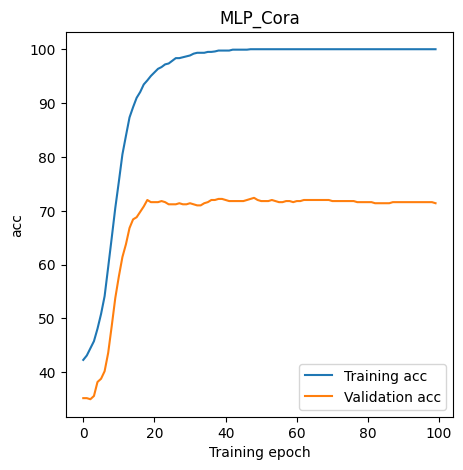

In [15]:
# Instantiate our model
model = SimpleMLP(input_dim=train_x.shape[-1], output_dim=7)

# Run training loop
train_stats_mlp_cora = train_eval_loop(model, train_x, train_y, valid_x, valid_y, test_x, test_y)
plot_stats(train_stats_mlp_cora, name="MLP_Cora")

In [16]:
cache, model_state = model.run_with_cache(test_x)

In [17]:
cache['layer_2_activation'].shape

torch.Size([1000, 7])

In [18]:
U, S, Vh = torch.linalg.svd(cache['layer_1_pre_activation'])
line(S, title="Principal Components of the Layer 1 Pre Activation")
U, S, Vh = torch.linalg.svd(cache['layer_1_post_activation'])
line(S, title="Principal Components of the Layer 1 Post Activation")
U, S, Vh = torch.linalg.svd(cache['layer_2_activation'])
line(S, title="Principal Components of the Layer 2 Activation")
# U, S, Vh = torch.linalg.svd(test_x)

In [19]:
### Code to convert to percentages
# # Step 1: Square the singular values to get the eigenvalues
# eigenvalues = torch.pow(S, 2)
# # Step 2: Compute the total variation (sum of eigenvalues)
# total_variation = torch.sum(eigenvalues)
# # Step 3: Calculate the explained variation for each singular value
# explained_variation = eigenvalues / total_variation
# # Step 4: Convert to percentage
# explained_variation_percentage = explained_variation * 100

🔎 We should be getting final test accuracies of around 72% on Cora for an extremely simple MLP model. Not too bad!

<font color='blue'> But are we using all the information/data available to us and can we do better with it? </font>

---




# 👶 Our first GCN layer

On our application of the MLP on Cora we have completely ignored the fact that Cora is a citation **network**!

In Cora, citations form undirected edges between each of the nodes (papers) in this network. We think this additional information can be useful for categorising our papers, but how can we incorporate this structure in a neural network layer?

In the course lectures, we were introduced to a general blue-print for creating GNN layers. We can build GNN layers $\mathbf{F(X,A)}$ on graphs by applying a local permutation invariant operation $\phi(\mathbf{x_i}, \mathbf{X}_{{N}_i})$. The various implementations of $\phi$ are the subject of much research.

For this practical, we will start by considering GNN layers with constant values for the convolution coefficients. Thus, we are interested in developing a Convolutional GNN layer that uses set parameters for the constant/coefficient $c_{i,j}$, for every edge $(i,j) \in E$

![](https://drive.google.com/uc?id=1Wdgdq606XW1MelvcU1nW5CxWe1rHsWt1)





The generic equation for a convolutional GNN looks as follows:

$$
\mathbf{h_i} = \phi \big(\mathbf{x_i}, \oplus_{j \in {N}_i} c_{i,j} \psi (\mathbf{x_j}) \big)
$$

Getting more specific, let us look at the **GCN** from Kipf and Welling's ["Semi-Supervised Classification with Graph Convolutional Networks"](https://arxiv.org/abs/1609.02907). This employs a symmetric normalisation for the convolution coefficients with a re-normalisation to tackle exploding parameters.

$$
\mathbf{H} = \sigma \big( \mathbf{\tilde{D}}^{-\frac{1}{2}} \mathbf{\tilde{A}} \mathbf{\tilde{D}}^{-\frac{1}{2}} \mathbf{X} \mathbf{W} \big)
$$

Where $\mathbf{\tilde{A}} = \mathbf{A} + \mathbf{I}$ and $\mathbf{\tilde{D}}$ is the degree matrix of $\mathbf{\tilde{A}}$.

Reformulating the above equation from a node-centric point of view corresponds to:

- $c_{i,j}$ is a normalising coefficient corresponding to $\frac{1}{\sqrt{(deg(i)+1) (deg(j)+1)}}$,
- $\oplus_{j \in {N}_i}$ is $\sum_{j \in {N}_i}$, i.e. the sum over neighbours,
- $\phi(\mathbf{x}_i, \mathbf{m}_i) = \sigma(c_{i,i}\psi(\mathbf{x}_i) + \mathbf{m}_i)$ with $\mathbf{m}_i = \sum_{j \in {N}_i} c_{i,j} \psi(\mathbf{x}_j)$.

The output node feature representation is the result of a weighted sum of itself and its neighbours, followed by a learnt affine transformation and non-linearity. The weights used for the weighted sum correspond to the connectivity/inverse of the degree of each node.


### 💻**Task 1.1**  <font color="purple"> Implement your first GNN layer based on the GCNLayer equations provided. (2.0 Marks) </font>

**Note:** In order to successfully pass the unit test, make sure you construct all of your linear layers using `torch.nn.Linear(in_features, out_features)`, _without_ adding any additional arguments to the constructor.

**Note:** When dealing with large, sparse matrices, multiplying them using sparse format is much more efficient. We do not impose doing that in this exercise but if you want to try [torch.tensor.to_sparse()](https://pytorch.org/docs/stable/generated/torch.Tensor.to_sparse.html) convert a dense matrix into a sparse matrix, while to [torch.sparse.mm()](https://pytorch.org/docs/stable/generated/torch.sparse.mm.html) perform multiplication between a sparse matrix and a sparse/dense matrix.

In [20]:
# @title [RUN] Hyperparameters for GCN

NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.01 #@param {type:"number"}

#you can add more here if you need

In [21]:
# Fill in the initialisation and forward method the GCNLayer below

class GCNLayer(Module):
    """Graph Convolutional Network layer from Kipf & Welling.

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, output_dim, A):
        super(GCNLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A

        # ============ YOUR CODE HERE ==============
        # Sample answer
        # Compute symmetric norm
        self.A_hat = A + torch.eye(A.size(0))                                 # A + I
        D_hat = torch.diag(torch.pow(self.A_hat.sum(1), -0.5))                # D^(-1/2)
        self.adj_norm = torch.matmul(torch.matmul(D_hat, self.A_hat), D_hat)  # D^(-1/2) A D^(-1/2)
        # + Simple linear transformation and non-linear activation
        self.linear = Linear(input_dim, output_dim)                           # W
        # ===========================================

    def forward(self, x):
        """Implements the forward pass for the layer

        Args:
            x (torch.Tensor): input node feature matrix
        """
        # ============ YOUR CODE HERE ==============
        x = torch.matmul(self.adj_norm, x)  # D^(-1/2) A D^(-1/2) X
        x = self.linear(x)                  # D^(-1/2) A D^(-1/2) X W
        # ===========================================
        return x

    def run_with_cache(self, x):
        """Implements the forward pass for the layer

        Args:
            x (torch.Tensor): input node feature matrix
        """
        layer_cache = {}
        # ============ YOUR CODE HERE ==============
        x = torch.matmul(self.adj_norm, x)  # D^(-1/2) A D^(-1/2) X
        layer_cache['Aggregation'] = x
        x = self.linear(x)                  # D^(-1/2) A D^(-1/2) X W
        layer_cache['Post Linear'] = x
        # ===========================================
        return x, layer_cache

In [22]:
# @title ✅ [RUN] **Please run this unit test to validate your code. The output would be used to mark your practical.**
def testing_gcn():
  torch.random.manual_seed(0)
  np.random.seed(0)
  A,x,y = get_dummy_data_transductive()

  input_dim = x.shape[-1]
  output_dim = y.shape[-1]

  torch.random.manual_seed(0)
  model = GCNLayer(input_dim, output_dim, A)
  out = model(x)

  assert(out.shape == (A.shape[0], output_dim)), "Oops! 🤭 Output shape is wrong"

  perm = np.random.permutation(x.shape[0])
  perm_x = x[perm]
  perm_out = out[perm]
  A_perm = A[perm, :][:, perm]

  torch.random.manual_seed(0)
  model_perm = GCNLayer(input_dim, output_dim, A_perm)

  out_model_perm = model_perm(perm_x)
  assert (torch.allclose(perm_out, out_model_perm, atol=1e-6)), "🤔 Something is wrong in the model! The output is not permutation equivariant anymore 🥺"

  assert (torch.allclose(out, y, atol=1e-6)), "🤔 Something is wrong in the model! The output is wrong."
  print("✅ All seems good!!!")


# run unit test function
testing_gcn()

✅ All seems good!!!


---

# **⚖ Semi-supervised learning on graphs:** Transductive vs Inductive

Notice that we use the entire adjacency and node feature matrix each time we call the GCNLayer as opposed to the specific subsets of the train/validation/test samples that we did earlier with the MLP. This is because nodes from the different splits share edges with those from the other splits and building our representation via the GCN requires these.

Hence, the learning performed with our GCNLayer is an instance of **transductive semi-supervised learning** as the model gets to see all of the observations in the dataset (even if it only has access to the labels from the training split).

This is different to the **inductive learning** performed on the MLP where the model only sees the train observations during training and only sees validation/test observations for prediction.




In [23]:
# @title [RUN] Helper functions for managing experiments, training, and evaluating models

def train_gnn_cora(X, y, mask, model, optimiser):
    model.train()
    optimiser.zero_grad()
    y_hat = model(X)[mask]
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimiser.step()
    return loss.data


def evaluate_gnn_cora(X, y, mask, model):
    model.eval()
    y_hat = model(X)[mask]
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)
    return accuracy


# Training loop
def train_eval_loop_gnn_cora(model, train_x, train_y, train_mask,
                        valid_x, valid_y, valid_mask,
                        test_x, test_y, test_mask
                    ):
    optimiser = Adam(model.parameters(), lr=LR)
    training_stats = None
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_gnn_cora(train_x, train_y, train_mask, model, optimiser)
        train_acc = evaluate_gnn_cora(train_x, train_y, train_mask, model)
        valid_acc = evaluate_gnn_cora(valid_x, valid_y, valid_mask, model)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f} validation accuracy: {valid_acc:.3f}")
        # store the loss and the accuracy for the final plot
        epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)
    # Lets look at our final test performance
    test_acc = evaluate_gnn_cora(test_x, test_y, test_mask, model)
    print(f"Our final test accuracy for the SimpleGNN is: {test_acc:.3f}")
    return training_stats

In [24]:
# Lets see the GCNLayer in action!

class SimpleGNN(Module):
    """A Simple GNN model using the GCNLayer for node classification

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, hidden_dim, output_dim, num_gcn_layers, A):
        super(SimpleGNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A

        # Note: if a single layer is used hidden_dim should be the same as input_dim
        if num_gcn_layers > 1:
          self.gcn_layers = [GCNLayer(input_dim, hidden_dim, A)]
          self.gcn_layers += [GCNLayer(hidden_dim, hidden_dim, A) for i in range(num_gcn_layers-2)]
          self.gcn_layers += [GCNLayer(hidden_dim, output_dim, A)]
        else:
          self.gcn_layers = [GCNLayer(input_dim, output_dim, A)]

        self.gcn_layers = ModuleList(self.gcn_layers)
        self.num_gcn_layers = num_gcn_layers

    def forward(self, x):
        """Forward pass through SimpleGNN on input x

        Args:
            x (torch.Tensor): input node features
        """
        for j in range(self.num_gcn_layers-1):
          x = self.gcn_layers[j](x)
          x = F.relu(x)

        x = self.gcn_layers[-1](x)

        y_hat = x
        return y_hat

    def run_with_cache(self, x):
        """Forward pass through SimpleGNN on input x

        Args:
            x (torch.Tensor): input node features
        """
        cache = {}
        for j in range(self.num_gcn_layers-1):
          x, cache_curr = self.gcn_layers[j].run_with_cache(x)
          cache[f"Layer {j} Pre Activation"] = cache_curr
          x = F.relu(x)
          cache[f"Layer {j} Post Activation"] = x
        x, cache_curr = self.gcn_layers[-1].run_with_cache(x)
        cache[f"Layer -1 Activation"] = cache_curr
        y_hat = x
        return cache, self.state_dict()

Epoch 0 with train loss: 1.941 train accuracy: 39.818 validation accuracy: 39.000
Epoch 10 with train loss: 1.117 train accuracy: 82.616 validation accuracy: 73.600
Epoch 20 with train loss: 0.678 train accuracy: 91.970 validation accuracy: 85.600
Epoch 30 with train loss: 0.463 train accuracy: 94.454 validation accuracy: 86.800
Epoch 40 with train loss: 0.346 train accuracy: 95.778 validation accuracy: 86.600
Epoch 50 with train loss: 0.274 train accuracy: 97.185 validation accuracy: 86.400
Epoch 60 with train loss: 0.226 train accuracy: 97.682 validation accuracy: 85.800
Epoch 70 with train loss: 0.191 train accuracy: 98.179 validation accuracy: 86.000
Epoch 80 with train loss: 0.164 train accuracy: 98.593 validation accuracy: 85.600
Epoch 90 with train loss: 0.144 train accuracy: 99.007 validation accuracy: 85.600
Our final test accuracy for the SimpleGNN is: 83.600


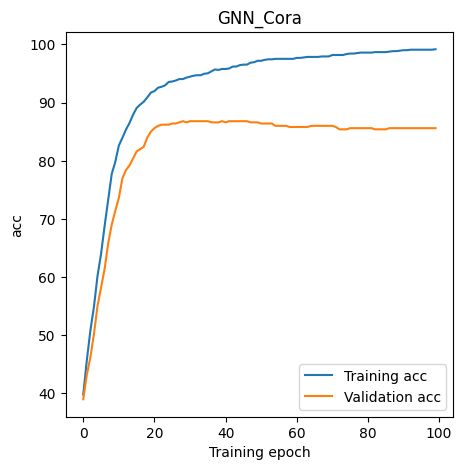

In [25]:
# Instantiate our model and optimiser
A = cora_data.get_adjacency_matrix()
X = cora_data.get_fullx()
model = SimpleGNN(input_dim=train_x.shape[-1], output_dim=7, A=A, hidden_dim=train_x.shape[-1], num_gcn_layers=1)
train_mask = cora_data.train_mask
valid_mask = cora_data.valid_mask
test_mask = cora_data.test_mask

# Run training loop
train_stats_gnn_cora = train_eval_loop_gnn_cora(model, X, train_y, train_mask,
                                          X, valid_y, valid_mask,
                                          X, test_y, test_mask
                                       )
plot_stats(train_stats_gnn_cora, name="GNN_Cora")

In [26]:
cache, state_dict = model.run_with_cache(X)

In [27]:
X.shape, cache['Layer -1 Activation']['Aggregation'].shape, cache['Layer -1 Activation']['Post Linear'].shape

(torch.Size([2708, 1433]), torch.Size([2708, 1433]), torch.Size([2708, 7]))

In [28]:
U, S, Vh = torch.linalg.svd(X)
line(S, title="Principal Components of the Input Graph Node Features")

U, S, Vh = torch.linalg.svd(cache['Layer -1 Activation']['Aggregation'])
line(S, title="Principal Components of the Layer 1 Pre Activation")

> 🔎 Alright! We got quite the boost here, seeing final test performances of about 84% despite no change to the number of trainable parameters being used. Neat! 👌

Note the use of the `train_mask`, `valid_mask`, and `test_mask` which we need to utilise as the model is able to see the entire dataset at all times. They are masking the outputs of the model to the observations corresponding to the dataset indices in each of the splits. For training this ensures that we compute the loss only over the training observations and ensure we don't have an information leak.

### 💻 <font color="purple">  Explore enlarging the receptive field visible to the computation of $\mathbf{H}$. First, how can this be done? Does this help? Try seeing this in action by changing the value of `num_gcn_layers` below and observing the effect of increasing the receptive field of your GNN on performance. </font>

In [29]:
# @title [RUN] Size of receptive field
num_gcn_layers = 2 #@param {type:"integer"}

Epoch 0 with train loss: 1.946 train accuracy: 28.477 validation accuracy: 31.800
Epoch 10 with train loss: 0.121 train accuracy: 96.689 validation accuracy: 87.400
Epoch 20 with train loss: 0.027 train accuracy: 99.338 validation accuracy: 85.800
Epoch 30 with train loss: 0.009 train accuracy: 99.669 validation accuracy: 86.000
Epoch 40 with train loss: 0.005 train accuracy: 99.834 validation accuracy: 84.600
Epoch 50 with train loss: 0.003 train accuracy: 99.917 validation accuracy: 84.400
Epoch 60 with train loss: 0.002 train accuracy: 99.917 validation accuracy: 84.600
Epoch 70 with train loss: 0.002 train accuracy: 99.917 validation accuracy: 84.600
Epoch 80 with train loss: 0.002 train accuracy: 99.917 validation accuracy: 84.600
Epoch 90 with train loss: 0.002 train accuracy: 99.917 validation accuracy: 83.800
Our final test accuracy for the SimpleGNN is: 81.300


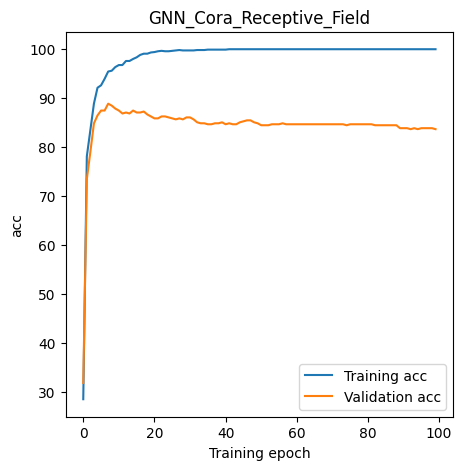

In [30]:
# ============ YOUR MODIFICATION HERE =============
# TASK: What do you need to change in this line to enlarge the receptive field?
model = SimpleGNN(input_dim=train_x.shape[-1], output_dim=7, A=A, hidden_dim=train_x.shape[-1], num_gcn_layers=num_gcn_layers)


# Run training loop
train_stats_gnn_cora_rf = train_eval_loop_gnn_cora(model, X, train_y, train_mask,
                                          X, valid_y, valid_mask,
                                          X, test_y, test_mask
                                       )
plot_stats(train_stats_gnn_cora_rf, name="GNN_Cora_Receptive_Field")


> ⏭ Great you've covered the basics of GNN layer development and studying node level prediction.

> Now lets look at **graph level prediction**. Consider the differences: we are no longer looking at each observation being a node (typically represented by an associated feature vector) but now each observation is an entire graph! As we do so, we run into our first challenge: *how do we batch graphs that can come in different sizes?* 🤔

---

#  🧬 **Supervised learning on graphs: Graph-level prediction**

Molecules are a great example of an object from nature that can easily be represented as a graph of atoms (nodes) connected by bonds (edges).
A popular application of GNNs in chemistry is the task of **Molecular Property Prediction**. The goal is to train a GNN model from historical experimental data that can predict useful properties of drug-like molecules. The model's predictions can then be used to guide the drug design process.

![](https://drive.google.com/uc?id=1Hs6fMSZ6a0WdjKqzbmBME0RYoSwxMaYQ)

One famous example of GNNs being used in molecular property prediction is in the world of **antibiotic discovery**, an area with a potentially massive impact on humanity and infamously little innovation. A GNN trained to predict how much a molecule would inhibit a bacteria was able identify the previously overlooked compound [**Halicin**](https://www.wikiwand.com/en/Halicin) (below) during virtual screening. Not only did halicin show powerful results during *in vitro* (in cell) testing but it also had a completely novel mechanism of action that no bacteria has developed resistance to (yet).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Halicin.svg/440px-Halicin.svg.png" width="30%">

In the following, we will explore molecular property prediction on the QM9 (Quantum Mechanics dataset 9) dataset. The dataset consists of about **130,000 small molecules** with 19 regression targets. Since being used by [MoleculeNet](https://arxiv.org/abs/1703.00564), it has become a popular dataset to benchmark new architectures for molecular property prediction.

Specifically, we will be predicting the [electric dipole moment](https://en.wikipedia.org/wiki/Electric_dipole_moment) of drug-like molecules. According to Wikipedia:
> "The electric dipole moment is a measure of the separation of positive and negative electrical charges within a system, that is, a measure of the system's overall polarity."

We can visualize this concept via the water molecule H<sub>2</sub>0, which forms a dipole due to its slightly different distribution of negative (blue) and postive (red) charge.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Water-elpot-transparent-3D-balls.png/500px-Water-elpot-transparent-3D-balls.png" width="25%">

You do not need to worry about the exact physical and chemical principles that underpin dipole moments. As you might imagine, writing the equations from first priciples to predict a property like this, espeically for complex molecules (e.g. proteins), is very difficult. All you need know is that these molecules can be represented as graphs with node and edge features as well as **spatial information** that we can use to train a GNN model using the ground truth labels.

Now let us load the QM9 dataset and explore how molecular graphs are represented. We will be using the PyTorch Geometric library to do so. (The dataset may take about 5min to download.)

**What is [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)?** PyG is a library for graph representation learning research and development:
> PyTorch Geometric (PyG) consists of various methods for deep learning on graphs and other irregular structures, also known as Geometric Deep Learning, from a variety of published papers. In addition, it provides easy-to-use mini-batch loaders for operating on many small and single giant graphs, multi GPU-support, distributed graph learning, a large number of common benchmark datasets, and helpful transforms, both for learning on arbitrary graphs as well as on 3D meshes or point clouds.

We will introduce PyG in detail subsequently.

In [31]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    path = './qm9'
    target = 0

    # Transforms which are applied during data loading:
    # Select the target/label
    transform = T.Compose([SetTarget()])

    # Load the QM9 dataset with the transforms defined
    dataset = QM9(path, transform=transform)

    # Normalize targets per data sample to mean = 0 and std = 1.
    mean = dataset.data.y.mean(dim=0, keepdim=True)
    std = dataset.data.y.std(dim=0, keepdim=True)
    dataset.data.y = (dataset.data.y - mean) / std
    mean, std = mean[:, target].item(), std[:, target].item()

## Data Preparation and Splitting

The QM9 dataset has over **130,000** molecular graphs!

Let us create a more tractable sub-set of **3,000** molecular graphs for the purposes of this practical and separate it into training, validation, and test sets. We shall use 1,000 graphs each for training, validation, and testing.

Feel free to experiment with the full/larger sub-sets of the QM9 dataset, too.

In [32]:
print(f"Total number of samples: {len(dataset)}.")

# Split datasets (in case of using the full dataset)
# test_dataset = dataset[:10000]
# val_dataset = dataset[10000:20000]
# train_dataset = dataset[20000:]

# Split datasets (our 3K subset)
train_pyg_dataset = dataset[:1000]
val_pyg_dataset = dataset[1000:2000]
test_pyg_dataset = dataset[2000:3000]
print(f"Created dataset splits with {len(train_pyg_dataset)} training, {len(val_pyg_dataset)} validation, {len(test_pyg_dataset)} test samples.")

Total number of samples: 130831.
Created dataset splits with 1000 training, 1000 validation, 1000 test samples.


## Visualising Molecular Graphs

To get a better understanding of how the QM9 molecular graphs look like, let's visualise a few samples from the training set along with their corresponding target (their dipole moment).

In the following plot we visualise the associated graph structure, where edges represent physical connections (i.e. bonds).

**❗️Note:** we have implemented some code for you to convert a QM9 graph into a Molecule object that can be used by RDKit, a python package for chemistry and visualing molecules. It is not important for you to understand RDKit beyond visualisation purposes.

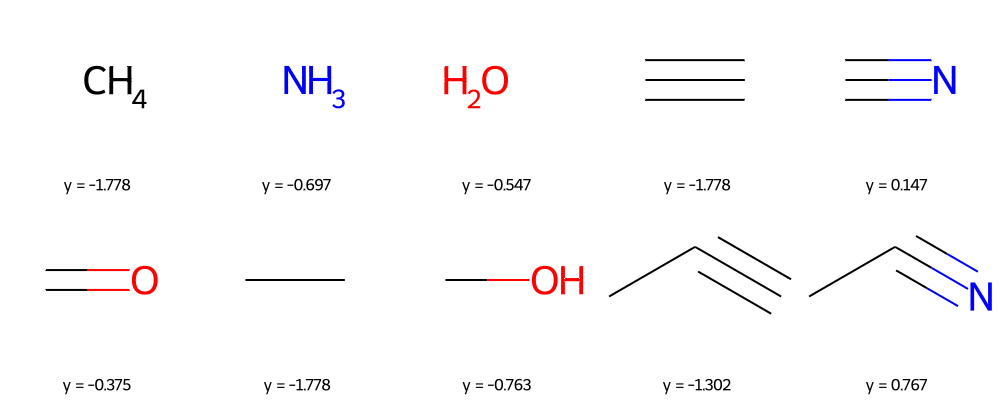

In [33]:
# @title [RUN] Visualise molecules from QM9

NUM_VIZ = 10 #@param {type:"integer"}

mols = [to_rdkit(train_pyg_dataset[i]) for i in range(NUM_VIZ)]
values = [str(round(float(train_pyg_dataset[i].y), 3)) for i in range(NUM_VIZ)]

Chem.Draw.MolsToGridImage(mols, legends=[f"y = {value}" for value in values], molsPerRow=5)

The loaded dataset is an instance of `torch_geometric.dataset`. Within an instance of a `Data` object, individual `Torch.Tensor` attributes (or any other variable type) can be easily dot accessed within a neural network layer. The graphs from PyG come with a number of pre-computed features which we describe below (do not worry if you are unfamiliar with the chemistry terms here):

**Atom features (`data.x`)** - $\mathbb{R}^{|V| \times 11}$
- 1st-5th features: Atom type (one-hot: H, C, N, O, F)
- 6th feature (also `data.z`): Atomic number (number of protons).
- 7th feature: Aromatic (binary)
- 8th-10th features: Electron orbital hybridization (one-hot: sp, sp2, sp3)
- 11th feature: Number of hydrogens

**Edge Index (`data.edge_index`)** - $\mathbb{R}^{2×|E|}$
- A tensor of dimensions 2 x `num_edges` that describe the edge connectivity of the graph

**Edge features (`data.edge_attr`)** - $\mathbb{R}^{|E|\times 4}$
- 1st-4th features: bond type (one-hot: single, double, triple, aromatic)

**Atom positions (`data.pos`)** - $\mathbb{R}^{|V|\times 3}$
- 3D coordinates of each atom . (We will talk about their importance later in the practical.)

**Target (`data.y`)** - $\mathbb{R}^{1}$
- A scalar value corresponding to the molecules electric dipole moment


For now, we will only use information regardin the features (`data.x`), structure (`data.edge_index`) and target(`data.y`), ignoring the edge attributes and the position of each atom.

In order to understand the internals of building GNNs in PyG, we will not (yet) directly use these original `torch_geometric` objects. Instead we will create a PyTorch wrapper class called ` Graph`. This class will store only the information needed for this task and will help us understand how PyG works under the hood.

**❗️Note:** Instead of storing an entire adjacency matrix to describe the graph structure (as in the previous section), we will store it in a  more efficient way as a list of edge indices of shape `[2, num_edges]`. Concretly, for each edge we store the indices of the source and destination node.



In [34]:
class Graph(object):
    def __init__(self, edge_index, x, y):
        """
        Minimal implementation of a Graph structure data object
        for a mini-batch of graphs. We will store a big (sparse)
        graph representing the entire batch.

        Args:
            x: node features  [num_nodes x num_feats]
            y: graph labels   [num_graphs]
            edge_index: list of edges [2 x num_edges]
        """
        self.edge_index = edge_index
        self.x = x.to(torch.float32)
        self.y = y
        self.num_nodes = self.x.shape[0]

    #ignore this for now, it will be useful for batching
    def set_batch(self, batch):
        """
        list of ints that maps each node to the graph it belongs to
        e.g. for batch = [0,0,0,1,1,1,1]: the first 3 nodes belong to graph_0
        while the last 4 belong to graph_1
        """
        self.batch = batch

    # this function returns a sparse tensor
    def get_adjacency_matrix(self):
        """
        from the list of edges create a
        num_nodes x num_nodes sparse adjacency matrix
        """
        return torch.sparse.LongTensor(
            self.edge_index,
            # we work with a binary adj containing 1 if an edge exist
            torch.ones((self.edge_index.shape[1])),
            torch.Size((self.num_nodes, self.num_nodes))
        )

    def __repr__(self):
        return f"{self.__class__.__name__}(num_nodes:{self.num_nodes} x:{self.x.shape} y:{self.y.shape} edge_index:{self.edge_index.shape})"

In [35]:
# @title [RUN] Convert PyG graphs to our new Graph class objects

def convert_dataset(pyg_dataset):
    dataset = []
    for graph in pyg_dataset:
        dataset.append(
            Graph(graph.edge_index, graph.x, graph.y)
        )
    return dataset

# Convert the dataset from list(Data) -> list(Graph)
train_dataset = convert_dataset(train_pyg_dataset)
val_dataset = convert_dataset(val_pyg_dataset)
test_dataset = convert_dataset(test_pyg_dataset)

# Check what the object contains
one_graph = train_dataset[0]
print(f"First graph contains {one_graph.x.shape[0]} nodes, with {one_graph.x.shape[1]} features each.")
print(f"Graph labels have shape: {one_graph.y.size(0)}")

First graph contains 5 nodes, with 11 features each.
Graph labels have shape: 1


Note that, for efficiency, the adjacency matrix (`self.get_adjacency_matrix()`) is stored as a sparse matrix (using `torch.sparse.LongTensor()`). This means that, instead of the entire matrix, we will only store the indexes of the vertices and the value (weight) corresponding to each edge. This saves lots of memory in storing the tensors for which the majority of elements are zeros.

If you need to convert a sparse tensor `x` into a dense one you can use `x.to_dense()`. Moreover, many operations are directly supported for sparse tensors via [`torch.sparse`](https://pytorch.org/docs/stable/sparse.html) (e.g. `torch.sparse.mm()` that multiplies a sparse matrix with a sparse/dense matrix).

---

# 🔠 Mini-batching for graph data

Since we are now dealing with **multiple graphs**, we need to figure out how to store them in **mini-batches**, to be able to make the computation as efficient as possible. For some types of data, stacking samples in mini-batches is a trivial task. For example, images of $32\times32$ pixels are easy to batch because they have the same dimension (obtaining a tensor of dimension $batch\_{size}\times32\times32$). On the other hand, graphs come in different sizes with adjacency matrices of different shapes:

In [36]:
print(f'First graph : {train_dataset[0].x.shape} with adjacency {(train_dataset[0].num_nodes, train_dataset[0].num_nodes)}')
print(f'Second graph: {train_dataset[1].x.shape} with adjacency {(train_dataset[1].num_nodes, train_dataset[1].num_nodes)}')
print(f'Third graph : {train_dataset[2].x.shape} with adjacency {(train_dataset[2].num_nodes, train_dataset[2].num_nodes)}')


First graph : torch.Size([5, 11]) with adjacency (5, 5)
Second graph: torch.Size([4, 11]) with adjacency (4, 4)
Third graph : torch.Size([3, 11]) with adjacency (3, 3)


One solution for this is to create a single *sparse* graph as the union of all the graphs in the mini-batch as follow:

1. stack the features $x$ for all the nodes in all the graphs
2. stack the labels $y$ for all the nodes in all the graphs
3. stack all the adjacency matrices $A_i$ as diagonal blocks in the new adjacency matrix

This way, we will obtain a new graph containing $\sum_{i=1}^{B}|V_i|$ nodes, where $B$ is the batch_size and by $|V_i|$ we denote the number of nodes in graph $i$. Note that since **no** edges connect nodes from different graphs,  the  information propagation will not be affected by the way we store it.  

<center>
<img src="https://drive.google.com/uc?export=view&id=1RwI0CYA57S0OgLxgHgV6PBFNG9tnGvGR" width="500">
</center>

<center>
<img src="https://drive.google.com/uc?export=view&id=1Ux65wTJLXCfJ4TI4Up4mCHkaSja8NgrJ" width="500">
</center>

As you can see, the resulting matrix contains many zeros (sparse), thus our choice of storing the adjacency matrix as a sparse tensor can indeed bring us efficiency.

---

Until now, we have a way to store the graphs in a mini-batch such that they could be efficiently processed.

However, we need to also be able to extract information from this structure, to recover the graphs that it contains. For this, we need to remember what initial graph each node belongs to.

We will do this by storing a list of indices `(self.batch)`, which map each node in the batch-graph to the initial graph it belong to. For example `batch=[0,0,0,1,1,2,2,2]` indicates that first 3 nodes belong to $G_0$, the next 2 nodes belong to $G_1$ and the last 3 nodes belong to $G_2$.

### 💻 **Task 1.2:** <font color="purple">Implement a mini-batching function for graph data which builds a single sparse graph from a batch of graphs (2.0 Marks) </font>


In [37]:
def create_mini_batch(graph_list: List[Graph]) -> Graph:
    """
    Function for built a single sparse graph from a batch of graphs.

    Args:
        graph_list: list of Graph objects in a batch
    Returns:
        a big (sparse) Graph representing the entire batch
    """
    # insert first graph into the structure
    batch_edge_index = graph_list[0].edge_index
    batch_x = graph_list[0].x
    batch_y = graph_list[0].y
    batch_batch = torch.zeros((graph_list[0].num_nodes), dtype=torch.int64)

    # ============ YOUR CODE HERE =============
    # define any additional variables you may need
    cum_num_nodes = graph_list[0].num_nodes  # cumulative number of nodes
    # ==========================================

    # append the rest of the graphs to the structure
    for idx, graph in enumerate(graph_list[1:]):

        # ============ YOUR CODE HERE =============
        # concat the features
        batch_x = torch.cat([batch_x, graph.x], dim=0)
        # concat the labels
        batch_y = torch.cat([batch_y, graph.y], dim=0)
        # concat the adjacency matrix as a block diagonal matrix
        edge_index_shifted = graph.edge_index + cum_num_nodes
        batch_edge_index = torch.cat([batch_edge_index, edge_index_shifted], dim=1)
        # ==========================================

        # ============ YOUR CODE HERE =============
        # create the array of indexes mapping nodes in the
        # batch-graph to the graph they belong to
        # specify the mapping between the new nodes and the graph they belong to (idx+1)
        graph_map = torch.full((graph.num_nodes,), idx+1, dtype=torch.int64)
        batch_batch = torch.cat([batch_batch, graph_map], dim=0)
        cum_num_nodes += graph.num_nodes
        # ==========================================

    # create the big sparse graph
    batch_graph = Graph(batch_edge_index, batch_x, batch_y)

    # attach the index array to the Graph structure
    batch_graph.set_batch(batch_batch)

    return batch_graph

Batch number_of_nodes: 12
Batch features shape: torch.Size([12, 32])
Batch labels shape: torch.Size([3])
Batch adjacency: 
1 1 1 0 0 0 0 0 0 0 0 0
1 1 1 0 0 0 0 0 0 0 0 0
1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 0 0 0 0
0 0 0 1 0 1 1 1 0 0 0 0
0 0 0 1 0 0 0 1 0 0 0 0
0 0 0 1 0 0 0 0 0 0 0 0
0 0 0 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0
0 0 0 0 0 0 0 0 0 0 1 0
0 0 0 0 0 0 0 0 0 0 0 1
0 0 0 0 0 0 0 0 1 0 0 0


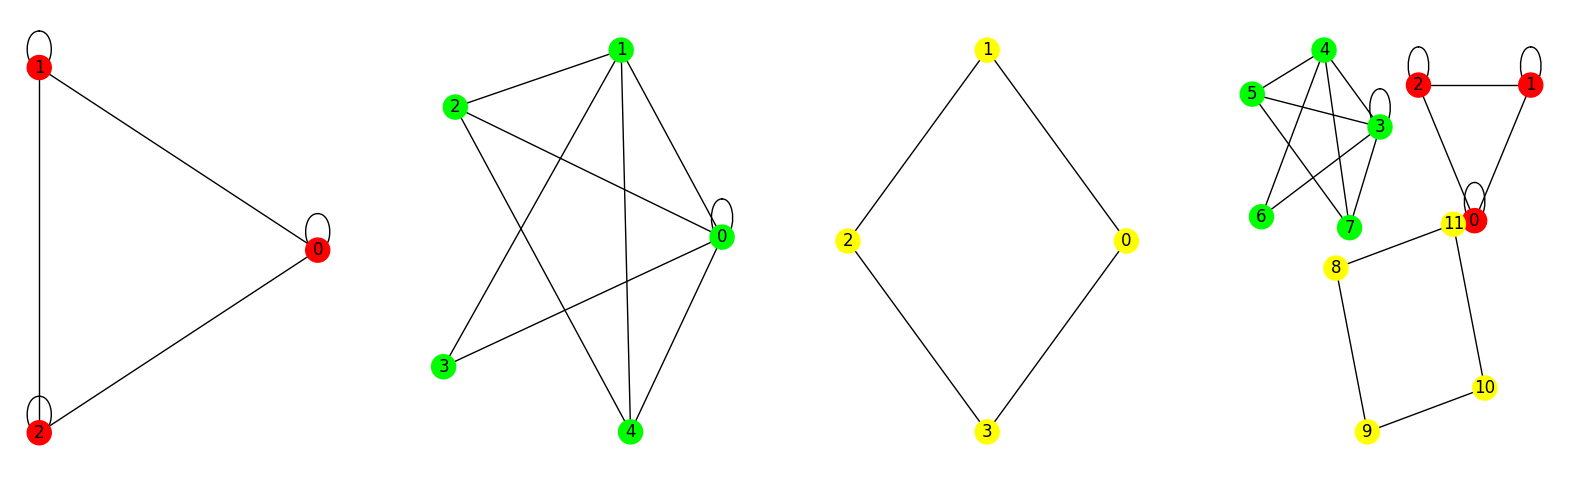

In [38]:
#@title Visualize the mini-batching for a small list of batch_size=3 graphs

# 3 random custom-designed graphs for visualisations
graph1 = Graph(x=torch.rand((3,32)),
               y=torch.rand((1)),
               edge_index=torch.tensor([[0,0,0,1,1,1,2,2,2],[0,1,2,0,1,2,0,1,2]]))
graph2 = Graph(x=torch.rand((5,32)),
               y=torch.rand((1)),
               edge_index=torch.tensor([[0,0,0,0,0,1,1,1,2,1,2,3,4], [0,1,2,3,4,2,3,4,4,0,0,0,0]]))
graph3 = Graph(x=torch.rand((4,32)),
               y=torch.rand((1)),
              edge_index=torch.tensor([[0,1,2,3],[1,2,3,0]]))
list_graphs = [graph1, graph2, graph3]

# create a mini-batch from these 3 graphs
batch_sample = create_mini_batch(list_graphs)
# show statistics about the new graph built from this batch of graphs
print(f"Batch number_of_nodes: {batch_sample.num_nodes}")
print(f"Batch features shape: {batch_sample.x.shape}")
print(f"Batch labels shape: {batch_sample.y.shape}")

print(f"Batch adjacency: ")
print_color_numpy(batch_sample.get_adjacency_matrix().to_dense().numpy(), list_graphs)

gallery([graph1, graph2, graph3, batch_sample], max_fig_size=(20,6), special_color=True)
print(f"And we also have access to which graph each node belongs to: {batch_sample.batch}\n")


In [39]:
# @title ✅ [RUN] **Please run this unit test to validate your code. The output would be used to mark your practical.**

def unit_test_mini_batch(batch):

  # create mini-batch using the function from task 1.2
  graph_batch = create_mini_batch(batch)

  # manually loop through samples to create lists used for asserts
  adj_list = []
  x_list = []
  y_list = []
  out_list = []
  for i in range(len(batch)):
    batch_i = create_mini_batch([batch[i]])
    batch_i_adj = batch_i.get_adjacency_matrix().to_dense()
    adj_list.append(batch_i_adj)
    x_list.append(batch_i.x)
    y_list.append(batch_i.y)

  adj_list_big = torch.block_diag(*adj_list)
  adj_batch = graph_batch.get_adjacency_matrix().to_dense()
  assert(torch.allclose(adj_batch, adj_list_big, atol=1e-6)), "The adjacency matrices are wrongly combined"

  x_list_big = torch.concat(x_list)
  assert(torch.allclose(x_list_big, graph_batch.x, atol=1e-6)), "The node features are wrongly combined"

  y_list_big = torch.concat(y_list)
  assert(torch.allclose(y_list_big, graph_batch.y, atol=1e-6)), "The node labels are wrongly combined"

  assert(torch.allclose(graph_batch.batch, torch.tensor([0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2]), atol=1e-6)), "The batch indexes are wrongly combined"
  print("✅ All seems good!!!")


# run unit test function
unit_test_mini_batch(list_graphs)

And we also have access to which graph each node belongs to: tensor([0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2])

✅ All seems good!!!


---

## The Scatter function for aggregating information

As you learned in the course, a simple way of aggregating information from node-level representation to obtain graph-level predictions is by (max/mean/sum) pooling. This can be efficiently obtained using the [`torch_scatter`](https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/mean.html) library containing operations such as `scatter_mean`, `scatter_max`, `scatter_sum`.

`scatter_*` receives as input a tensor and an array of indices and pools the information in the tensor stored at the indices specified in the array.

Here's what `scatter_sum(array, index)` looks like, visually:

<img src="https://drive.google.com/uc?export=view&id=16E9Nyd-mPdYBWm923joWKJx4JR8c8pCz" width="400">

### 💻 **Task 1.3:** <font color="purple"> Having access to all the nodes embedings in a batch, use `scatter_*` to create graph embedings for each graph in the batch. (0.5 Marks) </font>

In [40]:
array = torch.tensor([13, 21, 3, 7, 11, 20, 2])
index = torch.tensor([0,1,1,0,2,0,1])

aggregate_sum = scatter_sum(array, index, dim=0)
aggregate_mean = scatter_mean(array, index, dim=0)
aggregate_max, aggregate_argmax = scatter_max(array, index, dim=0)

print("Let's inspect what different scatter functions compute: ")
print(f"- sum aggregation output: {aggregate_sum}")
print(f"- mean aggregation output: {aggregate_mean}")
print(f"- max aggregation output: {aggregate_max}\n")

batch_qm9 = create_mini_batch(train_dataset[:3])
# ============ YOUR CODE HERE =============
# Given the nodes features for a batch of graphs (batch_qm9.x)
# and the list of indices indicating what graph each node belongs to
# apply scatter_* to obtain a graph embedings for each graph in the batch
# You can play with all of them (scatter_mean/scatter_max/scatter_sum)

node_emb = batch_qm9.x
node_batch = batch_qm9.batch
graph_emb = scatter_sum(node_emb, node_batch, dim=0)
# graph_emb = scatter_mean(node_emb, node_batch, dim=0)
# graph_emb, _ = scatter_max(node_emb, node_batch, dim=0)
print(node_emb.shape)
print(graph_emb.shape)
# ==========================================

Let's inspect what different scatter functions compute: 
- sum aggregation output: tensor([40, 26, 11])
- mean aggregation output: tensor([13,  8, 11])
- max aggregation output: tensor([20, 21, 11])

torch.Size([12, 11])
torch.Size([3, 11])


In [41]:
# @title ✅ [RUN] **Please run this unit test to validate your code. The output would be used to mark your practical.**

def unit_test_scatter():

  num_edges = len(set(batch_qm9.batch.numpy()))

  assert graph_emb.shape == (num_edges, batch_qm9.x.shape[-1]), "Output shape is unexpected."

  print("✅ All seems good!!!")

# run unit test function
unit_test_scatter()

✅ All seems good!!!


So far, we've learned:
1. how to store a batch of graphs in an efficient way,
2. how scatter operations work and how to use it to extract graph-level representations from node-level representations.

Let's integrate what we've learned so far in a Graph Neural Network model.

---

# 🔅 A simple Graph Neural Network for graph-level regression

We will now design a Graph Neural Network model, similar to the GCN used on Cora, with the following modifications:
* We are now working on graph-level prediction for molecular graphs from QM9, instead of node-level prediction on Cora.
* The task is regression instead of classification.
* We will use a simple sum aggregation instead of the symmetric normalised degree-based aggregation.

Concretly, the non-normalised GCN we will use for molecular property prediction can be express as:

\begin{equation}
\mathbf{X^{k+1}= \text{MLP}_k\big(AX^k + X^k\big)},
\end{equation}
where the MLP at the $k$th layer, $\text{MLP}_k$ is a multi-layer perceptron sequentially applies a Linear layer projecting the features from the input dimension to a hidden dimension, a ReLU activation, and another Linear projection from the hidden dimension to the output dimension.


In [42]:
# @title [RUN] Hyperparameters for molecular GCN

BATCH_SIZE =  128  #@param {type:"integer"}
NUM_EPOCHS =   30  #@param {type:"integer"}
HIDDEN_DIM =   64  #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}

#you can add more here if you need

### 💻 **Task 1.4:** <font color=purple> Implement a simple GNN for molecular property prediction on QM9. Most of the code is provided to you, but you have to fill in the missing part that implements the core message passing equation shown above. (1.0 Mark) </font>

**❗️Note:** A slight modification compared to the GCNLayer used in the Cora dataset is in the way we provide the adjacency matrix to the model. In the Cora setup, we provide the adjacency matrix in the `__init__` function,  while for QM9 we are giving it as argument in the `forward` function. This is due to the different nature of tasks we are tackling. While the Cora dataset is a transductive problem, where the entire dataset is a single graph, for the QM9 we have a lists of graphs, so we need to be able to provide a subset of them at each iteration.  

**❗️Note:** The MLP needs to be a 2-layer one as follow: Linear - ReLU - Linear

In [43]:
class GCNLayer(Module):
    """
    A single GCN layer, implementing MLP(AX + X)

    Args:
        in_feats (int): Dimensionality of input features
        out_feats (int): Dimensionality of output features
        hidden_dim (int): Dimensionality of hidden layers
    """

    def __init__(self, in_feats: int, out_feats: int, hidden_dim: int):
        super(GCNLayer, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats

        self.linear1 = Linear(self.in_feats, hidden_dim)
        self.linear2 = Linear(hidden_dim, self.out_feats)

    def forward(self, x, adj_sparse):
        """Forward pass through the GCNLayer given the input
        node features and the adjacency matrix

        Args:
            x (torch.Tensor): input node features
            adj_sparse (torch.sparse.LongTensor): adjacency matrix using sparse
                format
        """
        # ============ YOUR CODE HERE =============
        # aggregate the neighbours as in GCN: (AX + X)
        x = torch.sparse.mm(adj_sparse, x) + x # ask about this

        # project the features (MLP_k)
        x = self.linear1(x)
        x = F.relu(x)
        out = self.linear2(x)
        # =========================================
        return out

    def run_with_cache(self, x, adj_sparse):
        """Implements the forward pass for the layer

        Args:
            x (torch.Tensor): input node feature matrix
        """
        layer_cache = {}
        # ============ YOUR CODE HERE =============
        # aggregate the neighbours as in GCN: (AX + X)
        x = torch.sparse.mm(adj_sparse, x) + x # ask about this, there is a residual connection
        layer_cache['adj_sparse_out'] = x
        # project the features (MLP_k)
        x = self.linear1(x)
        layer_cache['linear1 pre act'] = x
        x = F.relu(x)
        layer_cache['linear1 post act'] = x
        out = self.linear2(x)
        layer_cache['linear2'] = out
        # =========================================
        return out, layer_cache

In [44]:
# @title ✅ [RUN] **Please run this unit test to validate your code. The output would be used to mark your practical.**

def unit_test_gcn():
  torch.random.manual_seed(0)
  np.random.seed(0)
  A,x,y = get_dummy_data_inductive_layer()

  input_dim = x.shape[-1]
  output_dim = y.shape[-1]

  torch.random.manual_seed(0)
  model = GCNLayer(in_feats=input_dim, out_feats=output_dim, hidden_dim=32)

  A_sparse = A.float().to_sparse_csr()
  out = model(x, A_sparse)

  assert(out.shape == (A.shape[0], output_dim)), "Something is wrong with your output shape"

  perm = np.random.permutation(x.shape[0])
  perm_x = x[perm]
  perm_out = out[perm]
  A_perm = A[perm, :][:, perm]
  A_perm_sparse = A_perm.float().to_sparse_csr()

  out_model_perm = model(perm_x, A_perm_sparse)

  assert (torch.allclose(perm_out, out_model_perm, atol=1e-6)), "Oops, something is wrong in the GCN implementation. You are not permutation equivariant anymore 🥺."

  assert (torch.allclose(out, y, atol=1e-6)), "🤔 Something is wrong in the model! The output is wrong."

  print("✅ All seems good!!!")

# run unit test function
unit_test_gcn()

✅ All seems good!!!


Using the above GCN Layer, let's design a neural network with `num_layers` GCNLayers, to solve the graph-regression task on QM9.


### 💻 **Task 1.5:** <font color=purple> Most of the code for a `SimpleGCN` model for  is provided. All you have to do is to fill-in the code that creates graph-representations from node-representations using the `scatter_sum` function you just learnt about (0.5 Mark) </font>

In [45]:
class SimpleGCN(Module):
    """
    A Graph Neural Network containing GCN layers for graph-level prediction

    The readout function used to obtain pooled graph-level representations
    is just the sum of the node features in the graph

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        hidden_dim (int): Dimensionality of the hidden layers
        num_layers (int): Number of layers
    """
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers=2):
        super(SimpleGCN, self).__init__()
        self.num_layers = num_layers # please select num_layers>=2
        # a linear layer to create embedding representations
        # based on each atom's input features
        self.embed_x = Linear(input_dim, hidden_dim)

        # instead of nn.Linear as in SimpleMLP model,
        # now we have (num_layers) GCNLayer(s), each with different parameters
        self.layers = [GCNLayer(hidden_dim, hidden_dim, hidden_dim) for _ in range(num_layers-1)]
        self.layers += [GCNLayer(hidden_dim, output_dim, hidden_dim)]
        self.layers = ModuleList(self.layers)

    def forward(self, graph):
        """Forward pass through the SimpleGCN given a (mini-batch of) graph.

        Args:
            graph (Graph): a graph object which contains one or more graphs and
                their attributes
        """
        adj_sparse = graph.get_adjacency_matrix()
        x = self.embed_x(graph.x)

        # sequentially apply GNN layers
        for i in range(self.num_layers-1):
          x = self.layers[i](x, adj_sparse)
          x = F.relu(x)
        x = self.layers[-1](x, adj_sparse)

        # ============ YOUR CODE HERE =============
        # graph-level representations are obtained by pooling info from the nodes using sum
        y_hat = scatter_sum(x, graph.batch, dim=0)
        # =========================================

        y_hat = y_hat.squeeze(-1)
        # also return the final node embeddings (for visualisations)
        return y_hat, x


    def run_with_cache(self, graph):
        """Forward pass through SimpleGNN on input x

        Args:
            x (torch.Tensor): input node features
        """
        cache = {}
        adj_sparse = graph.get_adjacency_matrix()
        cache['adj_sparse'] = adj_sparse
        x = self.embed_x(graph.x)
        cache['embed'] = x
        # sequentially apply GNN layers
        for i in range(self.num_layers-1):
          x , cache_curr = self.layers[i].run_with_cache(x, adj_sparse)
          cache[f"Layer {i} pre act"] = cache_curr
          x = F.relu(x)
          cache[f"Layer {i} post act"] = x
        x, cache_curr = self.layers[-1].run_with_cache(x, adj_sparse)
        cache[f"Layer -1 pre act"] = cache_curr

        # ============ YOUR CODE HERE =============
        # graph-level representations are obtained by pooling info from the nodes using sum
        y_hat = scatter_sum(x, graph.batch, dim=0)
        # =========================================
        cache['scatter sum'] = y_hat
        y_hat = y_hat.squeeze(-1)
        # also return the final node embeddings (for visualisations)
        return cache, model.state_dict()

In [46]:
# @title [RUN] Helper functions for managing experiments, training, and evaluating models

def train(dataset, model, optimiser, epoch, loss_fct, metric_fct, print_every):
    """ Train model for one epoch
    """
    model.train()
    num_iter = int(len(dataset)/BATCH_SIZE)
    for i in range(num_iter):
        batch_list = dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch = create_mini_batch(batch_list)
        optimiser.zero_grad()
        y_hat, _ = model(batch)
        loss = loss_fct(y_hat, batch.y)
        metric = metric_fct(y_hat, batch.y)
        loss.backward()
        optimiser.step()
        if (i+1) % print_every == 0:
          print(f"Epoch {epoch} Iter {i}/{num_iter}",
                    f"Loss train {loss.data}; Metric train {metric.data}")
    return loss.data, metric.data


def evaluate(dataset, model, loss_fct, metrics_fct):
    """ Evaluate model on dataset
    """
    model.eval()
    # be careful in practice, as doing this way we will lose some
    # examples from the validation split, when len(dataset)%BATCH_SIZE != 0
    # think about how can you fix this!
    num_iter = int(len(dataset)/BATCH_SIZE)
    metrics_eval = 0
    loss_eval = 0
    for i in range(num_iter):
        batch_list = dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch = create_mini_batch(batch_list)
        y_hat, _ = model(batch)
        metrics = metrics_fct(y_hat, batch.y)
        loss = loss_fct(y_hat, batch.y)

        metrics_eval += metrics.data
        loss_eval += loss.data
    metrics_eval /= num_iter
    loss_eval /= num_iter
    return loss_eval, metrics_eval


def train_eval(model, train_dataset, val_dataset, test_dataset,
               loss_fct, metric_fct, print_every=1):
    """ Train the model for NUM_EPOCHS epochs
    """
    #Instantiatie our optimiser
    optimiser = Adam(model.parameters(), lr=LR)
    training_stats = None

    #initial evaluation (before training)
    val_loss, val_metric = evaluate(val_dataset, model, loss_fct, metric_fct)
    train_loss, train_metric = evaluate(train_dataset[:BATCH_SIZE], model,
                                        loss_fct, metric_fct)
    epoch_stats = {'train_loss': train_loss, 'val_loss': val_loss,
                      'train_metric': train_metric, 'val_metric': val_metric,
                      'epoch':0}
    training_stats = update_stats(training_stats, epoch_stats)

    for epoch in range(NUM_EPOCHS):
        if isinstance(train_dataset, list):
            random.shuffle(train_dataset)
        else:
            train_dataset.shuffle()
        train_loss, train_metric = train(train_dataset, model, optimiser, epoch,
                                        loss_fct, metric_fct, print_every)
        val_loss, val_metric = evaluate(val_dataset, model, loss_fct, metric_fct)
        print(f"[Epoch {epoch+1}]",
                    f"train loss: {train_loss:.3f} val loss: {val_loss:.3f}",
                    f"train metric: {train_metric:.3f} val metric: {val_metric:.3f}"
              )
        # store the loss and the computed metric for the final plot
        epoch_stats = {'train_loss': train_loss, 'val_loss': val_loss,
                      'train_metric': train_metric, 'val_metric': val_metric,
                      'epoch':epoch+1}
        training_stats = update_stats(training_stats, epoch_stats)

    test_loss, test_metric = evaluate(test_dataset, model,  loss_fct, metric_fct)
    print(f"Test metric: {test_metric:.3f}")
    return training_stats

Now it's finally time to train our model and see the results.

In [47]:
# Instantiate our GCN model
model_simple_gcn = SimpleGCN(input_dim=batch_qm9.x.size()[-1], output_dim=1, hidden_dim=HIDDEN_DIM, num_layers=4)

# forward pass on dummy input
out, _ = model_simple_gcn(batch_qm9)
print(out.detach().numpy())

[0.34515026 0.26007044 0.20361838]


In [48]:
# @title ✅ [RUN] **Please run this unit test to validate your code. The output would be used to mark your practical.**
def testing_simple_gcn():
  torch.random.manual_seed(0)
  np.random.seed(0)
  A,x,y = get_dummy_data_inductive_model()

  input_dim = x.shape[-1]
  output_dim = y.shape[-1]

  torch.random.manual_seed(0)
  model = SimpleGCN(input_dim=input_dim, output_dim=output_dim, hidden_dim=32)

  A_sparse = A.to_sparse().indices()
  graph = create_mini_batch([Graph(x=x, y=y, edge_index=A_sparse)])
  out, _ = model(graph)

  assert (torch.allclose(out, y, atol=1e-6)), "🤔 Oops, something is wrong in the SimpleGCN implementation! The output is wrong."
  print("✅ All seems good!!!")

# run unit test function
testing_simple_gcn()

✅ All seems good!!!


[Epoch 1] train loss: 1.993 val loss: 2.321 train metric: 1.993 val metric: 2.321
[Epoch 2] train loss: 0.755 val loss: 1.347 train metric: 0.755 val metric: 1.347
[Epoch 3] train loss: 1.007 val loss: 0.991 train metric: 1.007 val metric: 0.991
[Epoch 4] train loss: 0.664 val loss: 0.948 train metric: 0.664 val metric: 0.948
[Epoch 5] train loss: 0.718 val loss: 0.934 train metric: 0.718 val metric: 0.934
[Epoch 6] train loss: 0.804 val loss: 0.946 train metric: 0.804 val metric: 0.946
[Epoch 7] train loss: 0.738 val loss: 1.049 train metric: 0.738 val metric: 1.049
[Epoch 8] train loss: 0.790 val loss: 0.874 train metric: 0.790 val metric: 0.874
[Epoch 9] train loss: 0.797 val loss: 0.964 train metric: 0.797 val metric: 0.964
[Epoch 10] train loss: 0.766 val loss: 1.029 train metric: 0.766 val metric: 1.029
[Epoch 11] train loss: 0.877 val loss: 1.097 train metric: 0.877 val metric: 1.097
[Epoch 12] train loss: 0.745 val loss: 1.093 train metric: 0.745 val metric: 1.093
[Epoch 13] tr

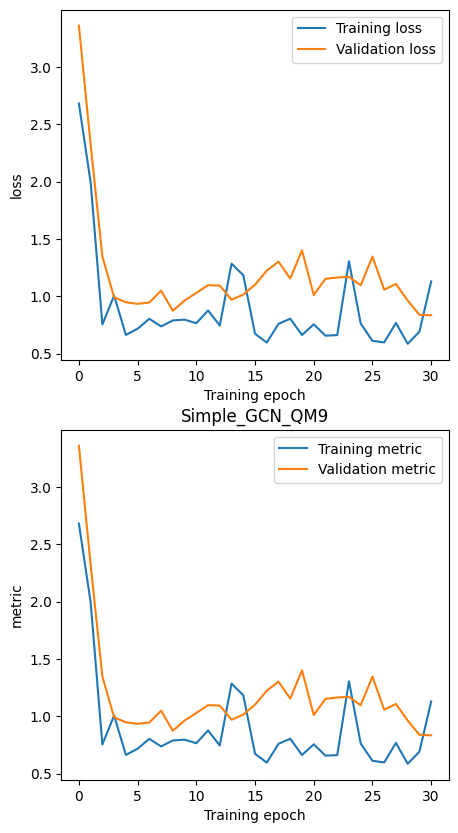

In [49]:
#Train GCN model:
train_stats_simple_gcn_qm9 = train_eval(model_simple_gcn, train_dataset, val_dataset,
                                        test_dataset, loss_fct=F.mse_loss,
                                        metric_fct=F.mse_loss, print_every=150)
plot_stats(train_stats_simple_gcn_qm9, name='Simple_GCN_QM9', figsize=(5, 10))

In [50]:

def get_cache(dataset, model):
    """ Evaluate model on dataset
    """
    model.eval()
    # be careful in practice, as doing this way we will lose some
    # examples from the validation split, when len(dataset)%BATCH_SIZE != 0
    # think about how can you fix this!
    BATCH_SIZE = len(dataset)

    num_iter = 1
    metrics_eval = 0
    loss_eval = 0
    for i in range(num_iter):
        batch_list = dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch = create_mini_batch(batch_list)
        cache, model_state = model.run_with_cache(batch)
    return cache, model_state

cache, model_state = get_cache(test_dataset, model_simple_gcn)

In [51]:
cache['Layer -1 pre act']['linear1 pre act']

tensor([[ 0.3418, -0.2054,  0.3096,  ...,  0.2472, -0.2406, -0.2415],
        [ 0.6265, -0.4960,  0.5426,  ...,  0.6633, -0.5800, -0.4960],
        [ 0.6310, -0.5698,  0.6066,  ...,  0.7481, -0.6842, -0.5941],
        ...,
        [ 0.3471, -0.2089,  0.3172,  ...,  0.2618, -0.2561, -0.2433],
        [ 0.3471, -0.2089,  0.3172,  ...,  0.2618, -0.2561, -0.2433],
        [ 0.3448, -0.1930,  0.3073,  ...,  0.2437, -0.2353, -0.2249]],
       grad_fn=<AddmmBackward0>)

---

# 🚀 Part 2: Going Geometric -- from vanilla PyTorch to PyG

Up until now you have implemented several graph neural networks for both substructure- and graph-level learning mostly on vanilla PyTorch. This was for pedagogic reasons and for you to appreciate the notorious difficulty of implementing these ''from scratch''.

For the remainder of this practical, we will make extensive use of **PyTorch Geometric**. If you have never worked with PyG before, do not worry, we will provide you with some examples and guide you through all the fundamentals in a detailed manner. We also highly recommend [this self-contained official tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html), which will help you get started. Among other things, you will learn how to implement state-of-the-art GNN layers via the generic PyG [Message Passing](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html) class (more on this later).

**❗️Note:** We will be using **sparse graphs** (where an edge between two atoms is present only when there exists a physical connection between them). At the end of the practical, we will share some code to study the advantages/downsides of fully-connected adjacency matrices versus sparse adjacency matrices.

---


# 🧪 [Intro] Molecular Property Prediction with PyG

Let us now look at the attributes of the PyG data objects that we initially loaded using the `QM9` dataset provided by PyG.

In [52]:
data = train_pyg_dataset[0]

print(f"\nThis molecule has {data.x.shape[0]} atoms, and {data.edge_attr.shape[0]} edges.")

print(f"\nFor each atom, we are given a feature vector with {data.x.shape[1]} entries (described above).")

print(f"\nFor each edge, we are given a feature vector with {data.edge_attr.shape[1]} entries (also described above).")

print(f"\nIn the next section, we will learn how to build a GNN in the Message Passing flavor to \n\
process the node and edge features of molecular graphs and predict their properties.")

print(f"\nEach atom also has a {data.pos.shape[1]}-dimensional coordinate associated with it. \n\
We will talk about their importance later in the practical.")

print(f"\nFinally, we have {data.y.shape[0]} regression target for the entire molecule.")


This molecule has 5 atoms, and 8 edges.

For each atom, we are given a feature vector with 11 entries (described above).

For each edge, we are given a feature vector with 4 entries (also described above).

In the next section, we will learn how to build a GNN in the Message Passing flavor to 
process the node and edge features of molecular graphs and predict their properties.

Each atom also has a 3-dimensional coordinate associated with it. 
We will talk about their importance later in the practical.

Finally, we have 1 regression target for the entire molecule.


## Using PyG for batching

As you might remember from the previous practical, **batching graphs** can be quite a tedious and fiddly process. Thankfully, using PyG makes this super simple! Given a list of `Data` objects, we can easily batch this into a PyG `Batch` object as well as unbatch back into a list of graphs. Furthermore, in simple cases like ours, the PyG `DataLoader` object (different from the vanilla PyTorch one) handles all of the batching under the hood for us!

Remember we have created sub-sets of molecular graphs (train, test, validation splits) from the QM9 dataset. Let us now load the datasets into the PyG `DataLoader`.

In [53]:
# Create dataloaders with batch size = 32
train_loader = DataLoader(train_pyg_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_pyg_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_pyg_dataset, batch_size=32, shuffle=False)

Lets quickly batch and unbatch some graphs as a demonstration:

In [54]:
# Toy graph 1
edge_index_1 = torch.tensor(
    [[0, 1, 1, 2], [1, 0, 2, 1]],
    dtype=torch.long
)
x_1 = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data_1 = Data(x=x_1, edge_index=edge_index_1)

# Toy graph 2
edge_index_2 = torch.tensor(
    [[0, 2, 1, 0], [2, 0, 0, 1]],
    dtype=torch.long
)
x_2 = torch.tensor([[1], [0], [-1]], dtype=torch.float)

data_2 = Data(x=x_2, edge_index=edge_index_2)

# Create batch from toy graphs
data_list = [data_1, data_2]
batch = Batch.from_data_list(data_list)

assert (batch[0].x == data_1.x).all() and (batch[1].x == data_2.x).all()

# Create DataLoader
loader = DataLoader(data_list, batch_size=1, shuffle=False)
it = iter(loader)
batch_1 = next(it)
batch_2 = next(it)

assert (batch_1.x == data_1.x).all() and (batch_2.x == data_2.x).all()

Awesome! So far, we have downloaded and prepared the QM9 dataset, visualised some samples, understood the attributes associated with each molecular graph, developed GNNs in pure PyTorch, and reviewed how batching works in PyG. Now, we are ready to understand how we can develop GNNs in PyG for molecular property prediction.

---

# 📩 [Intro] Introduction to Message Passing Neural Networks in PyTorch Geometric

As a gentle introduction to PyTorch Geometric, we will walk you through the first steps of developing a GNN in the **Message Passing** flavor.

![](https://drive.google.com/uc?id=1Wdgdq606XW1MelvcU1nW5CxWe1rHsWt1)

## Formalism

Firstly, let us formalise our molecular property prediction pipeline. (Our notation will mostly follow what has been introduced in the lectures, but we do make some different choices for variable names.)

### Graph
Consider a molecular graph $G = \left( V, {E} \right)$, where ${V}$ is a set of $n$ nodes, and ${E}$ is a set of edges associated with the nodes. For each node $i \in {V}$, we are given a $d_n$-dimensional initial feature vector $h_i \in \mathbb{R}^{d_n}$.
For each edge $(i, j) \in {E}$, we are given a $d_e$-dimensional initial feature vector $e_{ij} \in \mathbb{R}^{d_e}$. For QM9 graphs, $d_n = 11, d_e = 4$.

### Label/target
Associated with each graph ${G}$ is a scalar target or label $y \in \mathbb{R}^{1}$, which we would like to predict.

We will design a Message Passing Neural Network for graph property prediction to do this. Our MPNN will consist of several layers of message passing, followed by a global pooling and prediction head.

### MPNN Layer
The Message Passing operation iteratively updates node features $h_i^{\ell} \in \mathbb{R}^d$ from layer $\ell$ to layer $\ell+1$ via the following equation:
$$
h_i^{\ell+1} = \phi \Bigg( h_i^{\ell}, \oplus_{j \in {N}_i} \Big( \psi \left( h_i^{\ell}, h_j^{\ell}, e_{ij} \right) \Big) \Bigg),
$$
where $\psi, \phi$ are Multi-Layer Perceptrons (MLPs), and $\oplus$ is a permutation-invariant local neighborhood aggregation function such as summation, maximization, or averaging.

Let us break down the MPNN layer into three pedagogical steps:
- **Step (1): Message.** For each pair of linked nodes $i, j$, the network first computes a message $m_{ij} =  \psi \left( h_i^{\ell}, h_j^{\ell}, e_{ij} \right)$. The MLP $\psi: \mathbb{R}^{2d + d_e} → \mathbb{R}^d$ takes as input the concatenation of the feature vectors from the source node, destination node, and edge.
    - Note that for the first layer $\ell=0$, $h_i^{\ell=0} = W_{in} \left( h_i \right)$, where $W_{in} \in \mathbb{R}^{d_n}  \rightarrow \mathbb{R}^{d}$ is a simple linear projection (`torch.nn.Linear`) for the initial node features to hidden dimension $d$.
- **Step (2): Aggregate.** At each node $i$, the incoming messages from all its neighbors are then aggregated as $m_{i} = \oplus_{{j \in {N}_i}} \left( m_{ij} \right)$, where $\oplus$ is a permutation-invariant function. We will use summation, i.e. $\oplus_{{j \in {N}_i}} = \sum_{{j \in {N}_i}}$.
- **Step (3): Update.** Finally, the network updates the node feature vector $h_i^{\ell+1} = \phi \left( h_i^{\ell}, m_i \right)$, by concatenating the aggregated message $m_i$ and the previous node feature vector $h_i^{\ell}$, and passing them through an MLP $\phi: \mathbb{R}^{2d} → \mathbb{R}^{d}$.

### Global Pooling and Prediction Head
After $L$ layers of message passing, we obtain the final node features $h_i^{\ell=L}$. As we have a single target $y$ per graph, we must pool all node features into a single graph feature or graph embedding $h_G \in \mathbb{R}^d$ via another permutation-invariant function $R$, sometimes called the 'readout' function, as follows:
$$
h_G = R_{i \in {V}} \left( h_i^{\ell=L} \right).
$$
We will use global average pooling over all node features, i.e.
$$
h_G = \frac{1}{|{V}|} \sum_{i \in {V}} h_i^{\ell=L}.
$$

The graph embedding $h_G$ is passed through a linear prediction head $W_{pred} \in \mathbb{R}^{d} \rightarrow \mathbb{R}^1$ to obtain the overall prediction $\hat y \in \mathbb{R}^1$:
$$
\hat{y} = W_{pred} \left( h_G \right).
$$

### Loss Function
Our MPNN graph property prediction model can be trained end-to-end via minimizing the standard mean-squared error loss for regression:
$$
{L}_{MSE} = \lVert y - \hat y \rVert^2_2.
$$

## Coding the basic Message Passing Neural Network Layer

We are now ready to define a basic MPNN layer which implements what we have described above. In particular, we will code up the **MPNN Layer** first. (We will code up the other parts subsequently.)

To do so, we will inherit from the `MessagePassing` base class, which automatically takes care of message propagation and is extremely useful to develop advanced GNN models. To implement a custom MPNN, the user only needs to define the behaviour of the `message` (i.e. $\psi$), the `aggregate`(i.e. $\oplus$), and `update` (i.e. $\phi$) functions. You may also refer to the [PyG documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html) for implementing custom message passing layers.

Below, we provide the implementation of a standard MPNN layer as an example, with extensive inline comments to help you figure out what is going on.

In [65]:
!pip install torch_geometric==2.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.7 MB/s eta 0:00:00
  Attempting uninstall: torch_geometric
    Found existing installation: torch_geometric 2.5.1
    Uninstalling torch_geometric-2.5.1:
      Successfully uninstalled torch_geometric-2.5.1


In [66]:
from torch_geometric.nn import MessagePassing

class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # self.activations = {}  # Initialize a dictionary to store activations

        # MLP `\psi` for computing messages `m_ij`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: (2d + d_e) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        As our MPNNLayer class inherits from the PyG MessagePassing parent class,
        we simply need to call the `propagate()` function which starts the
        message passing procedure: `message()` -> `aggregate()` -> `update()`.

        The MessagePassing class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`,
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        # self.activations['input_h'] = h
        # self.activations['input_edge_attr'] = edge_attr
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        # self.activations['output'] = out
        return out

    def message(self, h_i, h_j, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j
        to destination nodes i for each edge (j, i) in `edge_index`.

        The arguments can be a bit tricky to understand: `message()` can take
        any arguments that were initially passed to `propagate`. Additionally,
        we can differentiate destination nodes and source nodes by appending
        `_i` or `_j` to the variable name, e.g. for the node features `h`, we
        can use `h_i` and `h_j`.

        This part is critical to understand as the `message()` function
        constructs messages for each edge in the graph. The indexing of the
        original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features, essentially h[edge_index[1]]
            h_j: (e, d) - source node features, essentially h[edge_index[0]]
            edge_attr: (e, d_e) - edge features

        Returns:
            msg: (e, d) - messages `m_ji` passed through MLP `\psi`
        """
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        message = self.mlp_msg(msg)
        # self.activations['message'] = message
        return message
    def aggregate(self, inputs, index):
        """Step (2) Aggregate

        The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ji` from source to destination nodes
            index: (e, 1) - list of destination nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        aggregated = scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
        # self.activations['aggregate'] = aggregated
        return aggregated

    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`,
        as well as any optional arguments that were initially passed to
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        upd_out = torch.cat([h, aggr_out], dim=-1)
        updated = self.mlp_upd(upd_out)
        # self.activations['update'] = updated
        return updated

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

Great! We have defined a **Message Passing layer** following the equation we had introduced previously. Let us use this layer to code up the full **MPNN graph property prediction model**. This model will take as input molecular graphs, process them via multiple MPNN layers, and predict a single property for each of them.

In [67]:
class MPNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        self.activations = {}


        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)
        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)

        for convidx, conv in enumerate(self.convs):
            hc = conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            h = h + hc
            self.activations[f'Layer {convidx} activations'] = conv.activations
            self.activations[f'Layer {convidx} pre res'] = hc
            self.activations[f'Layer {convidx} post res'] = h

            # Note that we add a residual connection after each MPNN layer


        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)
        self.activations[f'h_graph'] = h_graph
        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)
        self.activations[f'out'] = out
        return out.view(-1)

Awesome! We are done defining our first MPNN model for graph property prediction.

But wait! Before we dive into training and evaluation this model, let us write some sanity checks for a **fundamental property** of the model and the layer.

## Unit tests for Permutation Invariance and Equivariance

The lectures have repeatedly stressed on certain fundamental properties for machine learning on graphs:
- A **GNN <ins>layer**</ins> is **equivariant** to permutations of the set of nodes in the graph; i.e. as we permute the nodes, the node features produced by the GNN must permute accordingly.
- A **GNN <ins>model**</ins> for graph-level property prediction is **invariant** to the permutations of the set of nodes in the graph; i.e. as we permute the nodes, the graph-level properly remains unchanged.

(But wait...**What is a permutation?** Essentially, it is an **ordering of the nodes** in a graph. In general, there is **no canonical way** of assigning an ordering of the nodes, unlike textual or image data. However, graphs need to be stored and processed on computers in order to perform machine learning on them (which is what this course is about!). Thus, we need to ensure that our models are able to principally handle this **lack of canonical ordering** or permutation of graph nodes. This is what the above statements are trying to say.)

### Formalism

Let us try to formalise these notions of permutation invariance and equivariance via matrix notation (it is easier that way).

- Let $\mathbf{H} \in \mathbb{R}^{n \times d}$ be a matrix of node features for a given molecular graph, where $n$ is the number of nodes/atoms and each row $h_i$ is the $d$-dimensional feature for node $i$.
- Let $\mathbf{A} \in \mathbb{R}^{n \times n}$ be the adjacency matrix where each entry denotes $a_{ij}$ the presence or absence of an edge between nodes $i$ and $j$.
- Let $\mathbf{F}(\mathbf{H}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}^{n \times d}$ be a **GNN <ins>layer**</ins> that takes as input the node features and adjacency matrix, and returns the **updated node features**.
- Let $f(\mathbf{H}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}$ be a **GNN <ins>model**</ins> that takes as input the node features and adjacency matrix, and returns the **predicted graph-level property**.
- Let $\mathbf{P} \in \mathbb{R}^{n \times n}$ be a **[permutation matrix](https://en.wikipedia.org/wiki/Permutation_matrix)** which has exactly one 1 in every row and column, and 0s elsewhere. Left-multiplying $\mathbf{P}$ with a matrix changes the ordering of the rows of the matrix.

### Permutation Equivariance

The GNN <ins>layer</ins> $\mathbf{F}$ is **permutation equivariant** as follows:
$$
\mathbf{F}(\mathbf{PH}, \mathbf{PAP^T}) = \mathbf{P} \ \mathbf{F}(\mathbf{H}, \mathbf{A}).
$$

Another way to formulate the above could be: (1) Consider the updated node features $\mathbf{H'} = \mathbf{F}(\mathbf{H}, \mathbf{A})$. (2) Applying any permutation matrix $\mathbf{P}$ to the input of the GNN layer $\mathbf{F}$ should produce the same result as applying the same permutation on $\mathbf{H'}$:
$$
\mathbf{F}(\mathbf{PH}, \mathbf{PAP^T}) = \mathbf{P} \ \mathbf{H'}
$$

### Permutation Invariance

The GNN <ins>model</ins> $f$ for graph-level prediction is **permutation invariant** as follows:
$$
f(\mathbf{PH}, \mathbf{PAP^T}) = f(\mathbf{H}, \mathbf{A}).
$$

Another way to formulate the above could be: (1) Consider the predicted molecular property $\mathbf{\hat y} = f(\mathbf{H}, \mathbf{A})$. (2) Applying any permutation matrix $\mathbf{P}$ to the input of the GNN model $f$ should produce the same result as not applying it:
$$
f(\mathbf{PH}, \mathbf{PAP^T}) = \mathbf{\hat y}.
$$

With that formalism out of the way, let us write some unit tests to confirm that our `MPNNModel` and `MPNNLayer` are indeed permutation invariant and equivariant, respectively. (We have provided this for you).

In [68]:
def permute_graph(data, perm):
    """Helper function for permuting PyG Data object attributes consistently.
    """
    # Permute the node attribute ordering
    data.x = data.x[perm]
    data.pos = data.pos[perm]
    data.z = data.z[perm]
    data.batch = data.batch[perm]

    # Permute the edge index
    adj = to_dense_adj(data.edge_index)
    adj = adj[:, perm, :]
    adj = adj[:, :, perm]
    data.edge_index = dense_to_sparse(adj)[0]

    # Note:
    # (1) While we originally defined the permutation matrix P as only having
    #     entries 0 and 1, its implementation via `perm` uses indexing into
    #     torch tensors, instead.
    # (2) It is cumbersome to permute the edge_attr, so we set it to constant
    #     dummy values For any experiments beyond unit testing, all GNN models
    #     use the original edge_attr.

    return data

def permutation_invariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN model) is
    permutation invariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    out_1 = module(data)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    out_2 = module(data)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1, out_2, atol=1e-04)


def permutation_equivariance_unit_test(module, dataloader, with_pos=False):
    """Unit test for checking whether a module (GNN layer) is
    permutation equivariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Set edge_attr to dummy values (for simplicity)
    data.edge_attr = torch.zeros(data.edge_attr.shape)

    # Forward pass on original example
    if with_pos:
        out_1 = module(data.x, data.pos, data.edge_index, data.edge_attr)
    else:
        out_1 = module(data.x, data.edge_index, data.edge_attr)

    # Create random permutation
    perm = torch.randperm(data.x.shape[0])
    data = permute_graph(data, perm)

    # Forward pass on permuted example
    if with_pos:
        out_2 = module(data.x, data.pos, data.edge_index, data.edge_attr)
    else:
        out_2 = module(data.x, data.edge_index, data.edge_attr)

    # Check whether output varies after applying transformations
    return torch.allclose(out_1[perm], out_2, atol=1e-04)

Now that we have defined the unit tests for permutation invariance (for the full MPNN model) and permutation equivariance (for the MPNN layer), let us perform the sanity check:

In [69]:
# Instantiate temporary model, layer, and dataloader for unit testing
layer = MPNNLayer(emb_dim=11, edge_dim=4)
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
dataloader = DataLoader(train_pyg_dataset, batch_size=1, shuffle=True)

# Permutation invariance unit test for MPNN model
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")

# Permutation equivariance unit for MPNN layer
print(f"Is {type(layer).__name__} permutation equivariant? --> {permutation_equivariance_unit_test(layer, dataloader)}!")

TypeError: propagate() got an unexpected keyword argument 'h'

## Training and Evaluating Models

Great! We are finally ready to train and evaluate our model on QM9. We have provided a **basic experiment loop** which takes as input the model and dataloaders, performs training, and returns the final performance on the **validation** and **test set**.

We will be training a `MPNNModel` consisting of 4 layers of message passing with a hidden dimension of 64.

In [ ]:
#@title [RUN] Helper functions for managing experiments, training, and evaluating models.

def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.mse_loss(y_pred, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            # Mean Absolute Error using std (computed when preparing data)
            error += (y_pred * std - data.y * std).abs().sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):

    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)

    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)

        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)

        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')

        scheduler.step(val_error)
        perf_per_epoch.append((test_error, val_error, epoch, model_name))

    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")

    return best_val_error, test_error, train_time, perf_per_epoch

In [63]:
model = MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model,
    model_name,
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)
RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

NameError: name 'run_experiment' is not defined

In [ ]:
RESULTS

In [ ]:
p = sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 2));

In [ ]:
p = sns.lineplot(x="Epoch", y="Test MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 1));

Super! Everything up to this point has already been covered in the lectures, and we hope that the practical so far has been a useful recap along with the accompanying code.

Now for the fun part, where you will be required to think what you have studied so far!

---

#<font color=lightblue>  🧊 Geometric Graphs and Message Passing with 3D Coordinates

Remember that we were given **3D coordinates** with each atom in our molecular graph?

Molecular graphs, and other structured data occurring in nature, do not simply exist on flat planes. Instead, molecules have an **inherent 3D structure** that influences their properties and functions.

Let us visualize a molecule from QM9 in all of its 3D glory!

Go ahead and try move this molecule with your mouse cursor!

In [ ]:
MolTo3DView(smi2conf(Chem.MolToSmiles(to_rdkit(train_pyg_dataset[48]))))

## 💻 <font color=purple> **Task 2.1:** Develop a Message Passing Neural Network `CoordMPNNModel` that incorporates the atom coordinates as node features. **(1.0 Marks)**.


The `MPNNModel` we provided in the introduction above ignores the atom coordinates and only uses the node features to perform message passing. This means that the model is **not** leveraging useful **3D structural information** to predict the target property.

Your first task is to modify the original `MPNNModel` to incorporate **atom coordinates** into the **node features**.

We have defined most of the new `CoordMPNNModel` class for you, and you have to fill in the `YOUR CODE HERE` sections.

🤔 *Hint: As reminder, the 3D atom positions are stored in `data.pos`. You don't have to do something very smart right now (that will come later). A **simple** solution is okay to get started, e.g. concatenation or summation.*


In [ ]:
class CoordMPNNModel(MPNNModel):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        This model uses both node features and coordinates as inputs.

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        # ============ YOUR CODE HERE ==============
        # Adapt the input linear layer or add new input layers
        # to account for the atom positions.
        #
        # Linear projection for initial node features and coordinates
        # dim: ??? -> d
        self.lin_in = Linear(in_dim + 3, emb_dim)
        # ==========================================

        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        # ============ YOUR CODE HERE ==============
        # Incorporate the atom positions along with the features.
        #
        h = self.lin_in(torch.cat([data.x, data.pos], dim=1))
        # ==========================================

        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

Before we go on to evaluating the new MPNN, let us once again run the permutation sanity checks again to make sure the model and layer have the desired properties that constitute every basic GNN:
- The `MPNNLayer` should be permutation equivariant.
- The `CoordMPNNModel` should be permutation invariant.

In [ ]:
# @title ✅ [RUN] **Please run this unit test to validate your code. The output would be used to mark your practical.**
layer = MPNNLayer(emb_dim=11, edge_dim=4)
model = CoordMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)

dataloader = DataLoader(train_pyg_dataset, batch_size=1, shuffle=True)

# Permutation invariance unit test for MPNN model
is_permutation_invariant = permutation_invariance_unit_test(model, dataloader)
assert is_permutation_invariant, "🤔 Something is wrong in the model! Your CoordMPN is not permutation invariant 🥺"

# Permutation equivariance unit for MPNN layer
is_permutation_equivariant = permutation_equivariance_unit_test(layer, dataloader)
assert is_permutation_equivariant, "🤔 Something is wrong in the model! Your MPNN Layer is not permutation equivariant 🥺"

model = CoordMPNNModel(num_layers=1, emb_dim=1, in_dim=1, edge_dim=1, out_dim=1)

outs = torch.concatenate([model(dummy_data) for dummy_data in get_dummy_data()])
are_all_equal = torch.all(outs == outs[0])

assert not are_all_equal, "🤔 Something is wrong in the model! Your CoordMPN is not using the positional information 🥺"

print("✅ All seems good!!!")

In [ ]:
print(f"Is {type(model).__name__} permutation invariant? --> {is_permutation_invariant}!")
print(f"Is {type(layer).__name__} permutation equivariant? --> {is_permutation_equivariant}!")

## <font color = blue> 💻 [OPTIONAL] Train and evaluate your `CoordMPNNModel` with node features and coordinates on QM9.

Awesome! You are now ready to train and evaluate our new MPNN with node features and coordinates on QM9.

Re-use the experiment loop we have provided and fill in the `YOUR CODE HERE` sections to run the experiment.

You will be training a `CoordMPNNModel` consisting of 4 layers of message passing with a hidden dimension of 64, in order to compare your result fairly to the previous vanilla `MPNNModel`.

In [ ]:
# ============ YOUR CODE HERE ==============
# Instantiate your CoordMPNNModel with the appropriate arguments.
#
model = CoordMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
# ==========================================

model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model,
    model_name, # "MPNN w/ Features and Coordinates",
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)

RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

In [ ]:
RESULTS

In [ ]:
p = sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 2));

In [ ]:
p = sns.lineplot(x="Epoch", y="Test MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 1));

Hmm... If you've implemented the `CoordMPNNModel` correctly up till now, you may see a very curious result -- the performance of `CoordMPNNModel` is about equal or marginally worse than the vanilla `MPNNModel`!

This is because the `CoordMPNNModel` may not be using 3D structural information in the most principled manner.</font>

The next sections will help us formalise and understand why this is happening.

---

## 🔄 Invariance to 3D Symmetries: Rotation and Translation

We saw that the performance of `CoordMPNNModel` is unexpectedly mediocre compared to `MPNNModel` despite using both node features and coordinates. (But please do not panic if your results say otherwise.) In order to determine why, we must understand the concept of **3D symmetries**.

### Geometric Invariance

Recall that molecular graphs have 3D coordinates for each atom. A key detail which we have purposely withheld from you up till this point (😈) is that these 3D coordinates are **not  inherently fixed** or **permanent**. Instead, they were **experimentally determined** relative to a **frame of reference**.


The atoms' 3D coordinates might be given in various different reference frames which are rotated or translated with respect to each other. However, the **properties** of this molecule will always remain the same no matter how we rotate or translate it. In other words, the molecule's properties are **invariant** to 3D rotations and translations.

In this block we will study how to design GNN layers and models that respect these regularities.

### Formalism

Let us formalise the notion of invariance to 3D rotations and translations in GNNs via matrix notation.

- Let $\mathbf{H} \in \mathbb{R}^{n \times d}$ be a matrix of node features for a given molecular graph, where $n$ is the number of nodes/atoms and each row $h_i$ is the $d$-dimensional feature for node $i$.
- Let $\mathbf{X} \in \mathbb{R}^{n \times 3}$ be a matrix of node coordinates for a given molecular graph, where $n$ is the number of nodes/atoms and each row $x_i$ is the 3D coordinate for node $i$.
- Let $\mathbf{A} \in \mathbb{R}^{n \times n}$ be the adjacency matrix where each entry denotes $a_{ij}$ the presence or absence of an edge between nodes $i$ and $j$.
- Let $\mathbf{F}(\mathbf{H}, \mathbf{X}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times 3} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}^{n \times d}$ be a **GNN <ins>layer**</ins> that takes as input the node features, node coordinates, and adjacency matrix, and returns the **updated node features**.
- Let $f(\mathbf{H}, \mathbf{X}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times 3} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}$ be a **GNN <ins>model**</ins> that takes as input the node features, node coordinates, and adjacency matrix, and returns the **predicted graph-level property**.

(Notice that we have updated the notation for the GNN layer $\mathbf{F}$ and GNN model $\mathbf{f}$ to include the matrix of node coordinates $\mathbf{X}$ as an additional input.)


What does it mean for the GNN <ins>model</ins> $f$ and the GNN <ins>layer</ins> $\mathbf{F}$ to be invariant to 3D rotations and translations? Let's express this mathematically using the definitions above.

Let us define an orthogonal [**rotation matrix**](https://en.wikipedia.org/wiki/Rotation_matrix) $\mathbf{Q} \in \mathbb{R}^{3 \times 3}$ and [**translation vector**](https://en.wikipedia.org/wiki/Translation_(geometry)) $\mathbf{t} \in \mathbb{R}^3$ that operate on the matrix of node coordinates $\mathbf{X} \in \mathbb{R}^{n \times 3}$.
The GNN <ins>layer</ins> $\mathbf{F}$ is **rotation** and **translation invariant** as follows:
$$
\mathbf{F}(\mathbf{H}, \mathbf{X} \ \mathbf{Q} + \mathbf{t}, \mathbf{A}) = \mathbf{F}(\mathbf{H}, \mathbf{X}, \mathbf{A}).
$$

The GNN <ins>model</ins> $f$ for graph-level prediction is **rotation** and **translation invariant** as follows:
$$
f(\mathbf{H}, \mathbf{X} \ \mathbf{Q} + \mathbf{t}, \mathbf{A}) = f(\mathbf{H}, \mathbf{X}, \mathbf{A}).
$$
</font>

## 💻**Task 2.2:** Write the unit test to check your `CoordMPNNModel` for 3D rotation and translation invariance. **(1.0 Mark)**


🤔 *Hint: Show that the output of the model varies when:*
1. All the atom coordinates in `data.pos` are multiplied by any random _orthogonal_ rotation matrix $Q \in \mathbb{R}^{3 \times 3}$. (We have provided a helper function for creating rotation matrices.)
2. All the atom coordinates in `data.pos` are displaced by any random translation vector $\mathbf{t} \in \mathbb{R}^3$.

In [ ]:
def random_orthogonal_matrix(dim=3):
  """Helper function to build a random orthogonal matrix of shape (dim, dim)
  """
  Q = torch.tensor(ortho_group.rvs(dim=dim)).float()
  return Q


def rot_trans_invariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN model/layer) is
    rotation and translation invariant.
    """
    it = iter(dataloader)
    data = next(it)

    # Forward pass on original example
    # Note: We have written a conditional forward pass so that the same unit
    #       test can be used for both the GNN model as well as the layer.
    #       The functionality for layers will be useful subsequently.
    if isinstance(module, MPNNModel):
        out_1 = module(data)
    else: # if isinstance(module, MessagePassing):
        out_1 = module(data.x, data.pos, data.edge_index, data.edge_attr)

    Q = random_orthogonal_matrix(dim=3)
    t = torch.rand(3)
    # ============ YOUR CODE HERE ==============
    # Perform random rotation + translation on data.
    data.pos = torch.mm(data.pos, Q) + t
    # ==========================================

    # Forward pass on rotated + translated example
    if isinstance(module, MPNNModel):
        out_2 = module(data)
    else: # if isinstance(module, MessagePassing):
        out_2 = module(data.x, data.pos, data.edge_index, data.edge_attr)

    # ============ YOUR CODE HERE ==============
    # Check whether output varies after applying transformations.
    return torch.allclose(out_1, out_2, atol=1e-04)
    # ==========================================

In [ ]:
# @title ✅ [RUN] **Please run this unit test to validate your code. The output would be used to mark your practical.**
dataloader = DataLoader(train_pyg_dataset, batch_size=1, shuffle=True)

# Non-invariant unit test
is_3D_invariant = rot_trans_invariance_unit_test(dummy_not_invariant, dataloader)
assert not is_3D_invariant, "🤔 Something is wrong in your unit test! It gave a false positive 🥺"

# Only Translational Invariant unit test
is_3D_invariant = rot_trans_invariance_unit_test(dummy_only_trans_invariant, dataloader)
assert not is_3D_invariant, "🤔 Something is wrong in your unit test! Maybe you did not code a check for rotational invariance? 🥺"

# Only Rotational Invariant unit test
is_3D_invariant = rot_trans_invariance_unit_test(dummy_only_rot_invariant, dataloader)
assert not is_3D_invariant, "🤔 Something is wrong in your unit test! Maybe you did not code a check for translational invariance? 🥺"

# Invariant unit test
is_3D_invariant = rot_trans_invariance_unit_test(dummy_invariant, dataloader)
assert is_3D_invariant, "🤔 Something is wrong in your unit test! It gave a false negative 🥺"

print("✅ All seems good!!!")

Now that you have defined the unit tests for rotation and translation invariance, perform the sanity check on your `CoordMPNNModel`. Before you run it, pause a moment to think - what result would you expect?

In [ ]:
# Instantiate temporary model, layer, and dataloader for unit testing
model = CoordMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
dataloader = DataLoader(train_pyg_dataset, batch_size=1, shuffle=True)

# Rotation and translation invariance unit test for MPNN model
print(f"Is {type(model).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(model, dataloader)}!")

(<font color = red> 🔴 Spoiler alert: the unit test should return `False` for the `CoordMPNNModel`.)

In this part, you have formalised how a GNN can be 3D rotation and translation invariant, thought about why this is desirable for molecular property prediction, and shown that the `CoordMPNNModel` was not rotation and translation invariant.

At this point, you should have a concrete understanding of why the performance of `CoordMPNNModel` is equal or worse than the vanilla `MPNNModel`, and what we meant by our initial statement before we began this part:
>"The `CoordMPNNModel` may not be using 3D structural information in the most principled manner"

Let us try fixing this in the next part!

---

## ✈️ Upgrading message Passing with Invariance to 3D Rotations and Translations

This section will dive into how we may design GNN models which operate on graphs with 3D coordinates in a more theoretically sound way.

## <font color = purple> 💻 **Task 2.3:** Design a new Message Passing Layer as well as the accompanying MPNN Model that are both <ins>invariant</ins> to 3D rotations and translations. Verify this using the unit test you coded. **(3 Marks)**

**❗️ Note:** There are multiple ways to arrive at invariance, so there is no single correct answer to this question.

Our initial **'vanilla' MPNN** `MPNNModel` and `MPNNLayer` ignored the atom coordinates and only uses the node features to perform message passing. This means that the model was **not** leveraging **3D structural information** to predict the target property.

Our second **'naive' coordinate MPNN** `CoordMPNNModel` used the node features along with the atom coordinates in an unprincipled manner, resulting in the model not being invariant to 3D rotations and translations of the coordinates (which was a desirable property, as we saw in the previous part).

Your task is to define a new `InvariantMPNNLayer` which utilise both **atom coordinates** and **node features**.

We have defined most of the new `InvariantMPNNLayer`, and you have to fill in the `YOUR CODE HERE` sections. We have also already defined the `InvariantMPNNModel` that instantiates your new layer to compose the model. You only need to define the new layer.

🤔 *Hint 1: Unlike the previous `CoordMPNNModel`, we would suggest using the coordinate information to construct the messages as opposed to incorporating it into the node features. In particular, we would like to urge you to think about **how** we can use the coordinates in a principled manner to construct the messages: What is a quantity (or if you find multiple, what are quantities) that we can compute using a pair of coordinates that will be invariant to rotating and translating the coordinates?*

🤔 *Hint 2:  tensors passed to `propagate()` can be mapped to the respective nodes  and  by appending `_i` or `_j` to the variable name, e.g. `h_i` and `h_j` for the node features `h`. Note that we generally refer to `_i` as the central nodes that aggregates information, and refer to `_j` as the neighboring nodes.*

In [ ]:
class InvariantMPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        This layer is invariant to 3D rotations and translations.

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # ============ YOUR CODE HERE ==============
        # MLP `\psi` for computing messages `m_ij`
        # dims: 2d + e + 1 -> d
        #
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim + 1, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        # ==========================================

        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, pos, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        Args:
            h: (n, d) - initial node features
            pos: (n, 3) - initial node coordinates
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        # ============ YOUR CODE HERE ==============
        # Notice that the `forward()` function has a new argument
        # `pos` denoting the initial node coordinates. Your task is
        # to update the `propagate()` function in order to pass `pos`
        # to the `message()` function along with the other arguments.
        #
        out  = self.propagate(edge_index, h=h, edge_attr=edge_attr, pos=pos)
        return out
        # ==========================================

    # ============ YOUR CODE HERE ==============
    # Write a custom `message()` function that takes as arguments the
    # source and destination node features, node coordinates, and `edge_attr`.
    # Incorporate the coordinates `pos` into the message computation such
    # that the messages are invariant to rotations and translations.
    # This will ensure that the overall layer is also invariant.
    #
    def message(self, h_i, h_j, edge_attr, pos_i , pos_j):
        """The `message()` function constructs messages from source nodes j
          to destination nodes i for each edge (j, i) in `edge_index`.

        Args:
              h_i: (e, d) - destination node features, essentially h[edge_index[1]]
              h_j: (e, d) - source node features, essentially h[edge_index[0]]
              edge_attr: (e, d_e) - edge features
              pos_i: (e, 3)
              pos_j: (e, 3)
        Returns:
              msg: (e, d) - messages `m_ji` passed through MLP `\psi`
        """
        edge_dist = torch.norm(pos_i - pos_j, p=2, dim=1)
        edge_dist= edge_dist.unsqueeze(-1)
        msg = torch.cat([h_i, h_j, edge_attr, edge_dist], dim=-1)
        return self.mlp_msg(msg)
    # ==========================================

    def aggregate(self, inputs, index):
        """The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ji` from source to destination nodes
            index: (e, 1) - list of destination nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)

    def update(self, aggr_out, h):
        """The `update()` function computes the final node features by combining the
        aggregated messages with the initial node features.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')


class InvariantMPNNModel(MPNNModel):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        This model uses both node features and coordinates as inputs, and
        is invariant to 3D rotations and translations.

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)

        # Stack of invariant MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(InvariantMPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)

        for conv in self.convs:
            h = h + conv(h, data.pos, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

In [ ]:
# ============ YOUR CODE HERE ==============
# Instantiate temporary model, layer, and dataloader for unit testing.
# Remember that we are now unit testing the InvariantMPNNModel,
# which is  composed of the InvariantMPNNLayer.
#
layer = InvariantMPNNLayer(emb_dim=11, edge_dim=4)
model = InvariantMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
# ==========================================
dataloader = DataLoader(train_pyg_dataset, batch_size=1, shuffle=True)

# Rotation and translation invariance unit test for MPNN model
print(f"Is {type(model).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(model, dataloader)}!")

# Rotation and translation invariance unit test for MPNN layer
print(f"Is {type(layer).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(layer, dataloader)}!")

In [ ]:
# @title ✅ [RUN] **Please run this unit test to validate your code. The output would be used to mark your practical.**

# Permutation equivariance unit test for layer
is_permutation_equivariant = permutation_equivariance_unit_test(layer, dataloader, with_pos=True)
assert is_permutation_equivariant, "🤔 Something is wrong in the layer! Your layer is not permutation equivariant 🥺"

# 3D Invariance unit test for layer
is_rot_trans_invariant = rot_trans_invariance_unit_test(layer, dataloader)
assert is_rot_trans_invariant, "🤔 Something is wrong in the layer! Your layer is not rotation and translation invariant 🥺"

# 3D Invariance unit test for model
is_rot_trans_invariant = rot_trans_invariance_unit_test(model, dataloader)
assert is_rot_trans_invariant, "🤔 Something is wrong in the model! Your model is not rotation and translation invariant 🥺"

layer = InvariantMPNNLayer(emb_dim=1, edge_dim=1).eval()

# Setting all weights and biases to positive to avoid all outputs becoming 0 due to ReLU
layer = layer.requires_grad_(False)
for p in layer.parameters():
    torch.abs(p, out=p)

outs = torch.concatenate(
    [
        layer(dummy_data.x, dummy_data.pos, dummy_data.edge_index, dummy_data.edge_attr)
        for dummy_data in get_dummy_data()
    ]
)
are_all_equal = torch.all(outs == outs[0])

assert not are_all_equal, "🤔 Something is wrong in the model! Your model is not using the positional information 🥺"

print("✅ All seems good!!!")

Super! You have now defined a more geometrically principled message passing layer and used it to construct an MPNN model with is invariant to 3D rotations and translations.


It is finally time to run an experiment with our geometrically principled model!

## <font color = blue> 💻 [OPTIONAL] Train and evaluate your `InvariantMPNNModel`. Additionally, provide a few sentences explaining the model's results compared to the basic `MPNNModel` and the naive `CoordMPNNModel` defined previously. Is the new model visibly better?

Re-use the experiment loop we have provided and fill in the `YOUR CODE HERE` sections to run the experiment.

You will be training an `InvariantMPNNModel` consisting of 4 layers of message passing with a hidden dimension of 64, in order to compare your result fairly to the previous vanilla `MPNNModel` and naive `CoordMPNNModel`.

In [ ]:
# ============ YOUR CODE HERE ==============
# Instantiate your InvariantMPNNModel with the appropriate arguments.
#
model = InvariantMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
# ==========================================

model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model,
    model_name, # "MPNN w/ Features and Coordinates (Invariant Layers)",
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)

RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

In [ ]:
RESULTS

In [ ]:
p = sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 2));

In [ ]:
p = sns.lineplot(x="Epoch", y="Test MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 1));

Awesome! We have now gone from a vanilla `MPNNModel`, to a naive use of coordinate information in `CoordMPNNModel`, to a more geometrically principled approach in `InvariantMPNN` model.

In the next part, we will try to further push the limits of how much information we can derive from the geometry of molecules!

---
---
---

# 🚀 Message Passing with Equivariance to 3D Rotations and Translations

In the previous part of the practical, we studied the concepts of **3D rotation** and **translation** invariance. Now, we will go one step further. We will consider a GNN for molecular property prediction that is composed of message passing layers that are **equivariant** to 3D rotations and translations.

But why...you may ask.

In order to motivate the need for geometric equivariance and symmetries, we would like to take you back to the notion of permutation symmetries in GNNs for graphs, as well as translation symmetries in ConvNets for 2D images.

### Permutation Symmetry in GNNs vs. DeepSets

Earlier in the practical, we reviewed the concept of **permutation invariance** and **equivariance**. Fundamentally, a GNN layer must be a permutation <ins>equivariant</ins> operation on the graph nodes, i.e. changing the node ordering of the graph results in the same permutation applied to the node outputs of the layer. However, the overall GNN model for graph-level property prediction is still a **permutation <ins>invariant</ins>** function on the graph nodes, i.e. changing the node ordering does not impact the predicted graph property.

Recall from the lectures that the **[DeepSets model](https://arxiv.org/abs/1703.06114)** is yet another permutation <ins>invariant</ins> architecture over sets of nodes, and is a perfectly reasonable option for predicting graph-level properties (which are also permutation invariant, as we just stated). This raises a critical question: **why did we build permutation <ins>invariant</ins> GNN models composed of permutation <ins>equivariant</ins> GNN layers?**

One line of thinking is that permutation <ins>equivariant</ins> GNN layers enable the model to better leverage the **relational structure** of the underlying nodes, as well as construct more powerful node representations by **stacking several layers** of these permutation <ins>equivariant</ins> operations. (You can try running a DeepSets model for QM9 yourself and see the performance drop.)

Now, consider the same analogy for 3D rotation and translation symmetries for your molecular property prediction models. Consider your `InvariantMPNNModel` so far -- it is composed of `InvariantMPNNLayer` which are merely <ins>invariant</ins> to 3D rotations and translations.
By definition, applying these layers loses geometric information related to orientation or positioning (as this is precisely the type of information that is *not* invariant, but rather transforms covariantly with 3D transformations of the system).

Analogous to how permutation <ins>equivariant</ins> layer enabled GNNs to leverage relational structure in a more principled manner, a **3D rotation** and **translation <ins>equivariant</ins> layer** may enable your model to **leverage geometric structure** in a more principled manner, too.
For instance, equivariant layers may enable models to reason about how various sub-structures in molecules are spatially oriented w.r.t. one-another.
Solving such equivariant sub-tasks can often be critical for solving an overall invariant task.

Pablo Picasso's famous abstract protraits are a great way to motivate geometric equivariance:
<img src="https://drive.google.com/uc?id=1HNd850TrZlnWKraDi2HeGKP_x9PehEpN" width="100%">

### Translation Symmetry in ConvNets for 2D Images

Yet another example where <ins>invariant</ins> models are composed of <ins>equivariant</ins> layers is the ubiquitous **Convolutional Neural Network** for 2D images.
The ConvNet model is <ins>invariant</ins> to **translations**, in the sense that it will detect a cat in an image, regardless of where the cat is positioned in the image.

Importantly, the ConvNet is composed of **convolution filters** which are akin to sliding a rectangular window over the input image. Convolution filters are matching low level patterns within the image. Intuitively, one of these filters may be a cat detection filter, in that it will fire whenever it comes across cat-like pixels. Thus, convolution filters are translation <ins>equivariant</ins> functions since their output translates along with their input.

<img src="https://drive.google.com/uc?id=1vgTAG_n5r3H2nqo5vaZPyC60hbZMTEkN" width="100%">

([Source](https://bernhard-kainz.com/))

Translation <ins>invariant</ins> ConvNets are composed of translation <ins>equivariant</ins> convolution filters in order to build **hierarchical features** across multiple layers. Stacking deep ConvNets enables the features across layers to interact in a **compositional** manner and enables the overall network to learn increasingly **complex visual concepts**.


### Formalism

Hopefully, we have sufficiently motivated the need for 3D rotation and translation equivariant GNN layers. Let us now try to formalise the notion of equivariance to 3D rotations and translations via matrix notation.

- Let $\mathbf{H} \in \mathbb{R}^{n \times d}$ be a matrix of node features for a given molecular graph, where $n$ is the number of nodes/atoms and each row $h_i$ is the $d$-dimensional feature for node $i$.
- Let $\mathbf{X} \in \mathbb{R}^{n \times 3}$ be a matrix of node coordinates for a given molecular graph, where $n$ is the number of nodes/atoms and each row $x_i$ is the 3D coordinate for node $i$.
- Let $\mathbf{A} \in \mathbb{R}^{n \times n}$ be the adjacency matrix where each entry denotes $a_{ij}$ the presence or absence of an edge between nodes $i$ and $j$.
- Let $\mathbf{F}(\mathbf{H}, \mathbf{X}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times 3} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}^{n \times d}\times \mathbb{R}^{n \times 3}$ be a **GNN <ins>layer**</ins> that takes as input the node features, node coordinates, and adjacency matrix, and returns the **updated node features** as well as **updated node coordinates**.
- Let $f(\mathbf{H}, \mathbf{X}, \mathbf{A}): \mathbb{R}^{n \times d} \times \mathbb{R}^{n \times 3} \times \mathbb{R}^{n \times n} \rightarrow \mathbb{R}$ be a **GNN <ins>model**</ins> that takes as input the node features, node coordinates, and adjacency matrix, and returns the **predicted graph-level property**.

Our GNN <ins>model</ins> $f(\mathbf{H}, \mathbf{X}, \mathbf{A})$ is composed of multiple rotation and translation equivariant GNN <ins>layers</ins> $\mathbf{F}^{\ell}(\mathbf{H}^{\ell}, \mathbf{X}^{\ell}, \mathbf{A}), \ell = 1, 2, \dots, L$.

### How is this different from Geometrically Invariant Message Passing?

Importantly, and in contrast to rotation and translation invariant message passing layers, each round of equivariant message passing updates both the **node features** as well as the **node coordinates**:
$$
\mathbf{H}^{\ell+1}, \mathbf{X}^{\ell+1} = \mathbf{F}^{\ell} (\mathbf{H}^{\ell}, \mathbf{X}^{\ell}, \mathbf{A}).
$$

Such a formulation is highly beneficial for GNNs to learn useful node features in settings where we are modelling a **dynamical system** and have reason to believe that the node coordinates are continuously being updated, e.g. by the action of **intermolecular forces**.

Do note the following nuances about geometrically equivariant message passing layers $\mathbf{F}$:
- The updated **node coordinates** $\mathbf{X'}$ are **equivariant** to 3D rotations and translations of the input coordinates $\mathbf{X}$.
- The updated **node features** $\mathbf{H'}$ are still **invariant** to 3D rotations and translations of the input coordinates $\mathbf{X}$ (similar to the geometrically invariant message passing layer).
- The overall **MPNN model** $f$ will still be **invariant** to 3D rotations and translations. This is because we are predicting a **single scalar quantity** (the electric dipole moment) per molecule, which remains unchanged under any rotations and translations of the atoms' coordinates. Thus, the final node feature vectors after $L$ layers of message passing are aggregated into a graph embedding (and the final node coordinates are ignored). The graph embedding is then used to predict the target.

The following figure aims to succinctly capture these nuances about geometrically equivariant message passing layers $\mathbf{F}$ which are used to compose a geometrically invariant GNN $\mathbf{f}$:

<img src="https://drive.google.com/uc?id=1rRsjM8AdxiU-uJ7C5t1JDMkC19QKdGPg" width="100%">

What we want you to investigate in this part is how we may improve a **GNN model** that is **invariant** to 3D rotations and translations by using **message passing layers** that are **equivariant** to these **3D symmetries**.

Let us get started!

### The GNN <ins>layer</ins> $\mathbf{F}$ is equivariant to 3D rotations and translations. Let's express this mathematically using the definitions above.



Let us define an orthogonal rotation matrix $\mathbf{Q} \in \mathbb{R}^{3 \times 3}$ and translation vector $\mathbf{t} \in \mathbb{R}^3$.


The GNN layer $\mathbf{F}$ is **rotation** and **translation equivariant** as follows:
$$
\mathbf{F}(\mathbf{H}, \mathbf{X} \ \mathbf{Q} + \mathbf{t}, \mathbf{A}) = \mathbf{Q} \ \mathbf{F}(\mathbf{H}, \mathbf{X}, \mathbf{A}) + \mathbf{t}.
$$


Another way to formulate the above could be: (1) Consider the updated node features and coordinates $\mathbf{H'}, \mathbf{X'} = \mathbf{F}(\mathbf{H}, \mathbf{X}, \mathbf{A})$. (2) Applying any rotation matrix $\mathbf{Q}$ and translation vector $\mathbf{t}$ to the input coordinates $\mathbf{X}$ of the GNN layer $\mathbf{F}$ should produce the same result as applying the same transformations on the updated coordinates $\mathbf{X'}$:
$$
\mathbf{F}(\mathbf{H}, \mathbf{X} \ \mathbf{Q} + \mathbf{t}, \mathbf{A}) = \mathbf{H'}, \mathbf{Q} \ \mathbf{X'} + \mathbf{t}.
$$

Before we code up an equivariant layer, we will first write a unit test (like all good programmers 😄).

## <font color = purple> 💻 **Task 2.4:** Write a unit test for 3D rotation and translation equivariance for a GNN layer. **(1.0 Mark)**

In [ ]:
def rot_trans_equivariance_unit_test(module, dataloader):
    """Unit test for checking whether a module (GNN layer) is
    rotation and translation equivariant.

    module returns a tuple -- updated features and updated positions.
    """
    it = iter(dataloader)
    data = next(it)

    out_1, pos_1 = module(data.x, data.pos, data.edge_index, data.edge_attr)

    Q = random_orthogonal_matrix(dim=3)
    t = torch.rand(3)
    # ============ YOUR CODE HERE ==============
    # Perform random rotation + translation on data.
    data.pos = torch.mm(data.pos, Q) + t
    # ==========================================

    # Forward pass on rotated + translated example
    out_2, pos_2 = module(data.x, data.pos, data.edge_index, data.edge_attr)

    # ============ YOUR CODE HERE ==============
    # Check whether output varies after applying transformations.
    pos_2_back = torch.mm(pos_2 - t.unsqueeze(0), Q.t())
    out_res = torch.allclose(out_1, out_2, atol=1e-04)      # checks invariance
    pos_res = torch.allclose(pos_1, pos_2_back, atol=1e-04) # checks equivariance
    return pos_res and out_res
    # ==========================================

In [ ]:
# @title ✅ [RUN] **Please run this unit test to validate your code. The output would be used to mark your practical.**
dataloader = DataLoader(train_pyg_dataset, batch_size=1, shuffle=True)

# Non-Equivariant unit test
is_3D_equivariant = rot_trans_equivariance_unit_test(dummy_not_equivariant, dataloader)
assert not is_3D_equivariant, "🤔 Something is wrong in your unit test! It gave a false positive 🥺"

# Node Features not invariant unit test
is_3D_equivariant = rot_trans_equivariance_unit_test(dummy_h_not_invariant, dataloader)
assert not is_3D_equivariant, "🤔 Something is wrong in your unit test! Maybe you did not code a check for invariance of node features? 🥺"

# Only Translation Invariant Features unit test
is_3D_equivariant = rot_trans_equivariance_unit_test(dummy_h_only_trans_invariant, dataloader)
assert not is_3D_equivariant, "🤔 Something is wrong in your unit test! Maybe you did not code a check for rotational invariance of node features? 🥺"

# Only Rotational Invariant Features unit test
is_3D_equivariant = rot_trans_equivariance_unit_test(dummy_h_only_rot_invariant, dataloader)
assert not is_3D_equivariant, "🤔 Something is wrong in your unit test! Maybe you did not code a check for translational invariance of node features? 🥺"

# Node Positions not invariant unit test
is_3D_equivariant = rot_trans_equivariance_unit_test(dummy_x_not_equivariant, dataloader)
assert not is_3D_equivariant, "🤔 Something is wrong in your unit test! Maybe you did not code a check for equivariance of node positions? 🥺"

# Only Translation Equivariant Positions unit test
is_3D_equivariant = rot_trans_equivariance_unit_test(dummy_x_only_trans_equivariant, dataloader)
assert not is_3D_equivariant, "🤔 Something is wrong in your unit test! Maybe you did not code a check for rotational equivariance of node positions? 🥺"

# Only Rotational Equivariant Positions unit test
is_3D_equivariant = rot_trans_equivariance_unit_test(dummy_x_only_rot_equivariant, dataloader)
assert not is_3D_equivariant, "🤔 Something is wrong in your unit test! Maybe you did not code a check for translational equivariance of node positions? 🥺"

# Equivariant unit test
is_3D_equivariant = rot_trans_equivariance_unit_test(dummy_equivariant, dataloader)
assert is_3D_equivariant, "🤔 Something is wrong in your unit test! It gave a false negative 🥺"

print("✅ All seems good!!!")

## <font color = purple> 💻 **Task 2.5:** Design a new Message Passing Layer that is <ins>equivariant</ins> to 3D rotations and translations. Verify the equivariance of your layer and invariance of the resulting model using your unit test. **(3.0 Marks)**

🤔 *Hint 1: To ensure equivariance to 3D rotations and translations, your message passing layer should now update both the node features as well as the node coordinates. This means that each of the `message()`, `aggregate()`, and `update()` functions will be passing around a tuple of outputs, consisting of the node features and node coordinates.*

🤔 *Hint 2: Certain quantities that can be computed among a pair of node coordinates do not change when the coordinates are rotated or translated -- these are **invariant quantities**. On the other hand, certain quantities may rotate or translate along with the coordinates -- these are **equivariant quantities**. We want you to think about how you can set up the message passing in a way that messages for the node feature updates are <ins>invariant</ins> to 3D rotations and translations, while messages for the node coordinates are <ins>equivariant</ins> to the same.*

**❗️Note:** This task has multiple possible approaches for achieving. Directly importing or copying implementations from PyG will not be accepted as a valid answer.

**❗️Note:** The trivial solution $\mathbf{X}^{\ell+1} = \mathbf{X}^{\ell}$ will not be accepted as a valid answer. A general intuition about GNNs is that each node learns how to **borrow information** from its neighbours — here, this holds true for both node feature information as well as node coordinate information. Thus, we want you to use message passing to update the node coordinates by aggregating from the node coordinates of the neighbours. The ‘game’ here is about how to design a learnable message function for the coordinates such that it is equivariant to 3D symmetries.

In [ ]:
class EquivariantMPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        This layer is equivariant to 3D rotations and translations.

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # ============ YOUR CODE HERE ==============
        # Define the MLPs constituting your new layer.
        # At the least, you will need `\psi` and `\phi`
        # (but their definitions may be different from what
        # we used previously).
        #


        # self.mlp_msg = ...  # MLP `\psi`
        # dims: (2d + d_e) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim + 1, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

        # MLP `\psi` for computing messages `m_ij`
        # dims: d -> 1 # this was initially 1, I also tried 3
        self.mlp_pos = Sequential(
            Linear(3, emb_dim), BatchNorm1d(emb_dim),
            Linear(emb_dim, 1), BatchNorm1d(1)
        )

        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(emb_dim + emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        # ===========================================

    def forward(self, h, pos, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        Args:
            h: (n, d) - initial node features
            pos: (n, 3) - initial node coordinates
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: [(n, d),(n,3)] - updated node features
        """
        # ============ YOUR CODE HERE ==============
        # Notice that the `forward()` function has a new argument
        # `pos` denoting the initial node coordinates. Your task is
        # to update the `propagate()` function in order to pass `pos`
        # to the `message()` function along with the other arguments.
        #
        out  = self.propagate(edge_index, h=h, edge_attr=edge_attr, pos=pos)
        return out
        # ==========================================

    # ============ YOUR CODE HERE ==============
    # Write custom `message()`, `aggregate()`, and `update()` functions
    # which ensure that the layer is 3D rotation and translation equivariant.
    #
    def message(self, h_i, h_j, edge_attr, pos_i , pos_j):

        # msg = torch.cat([h_i, h_j, edge_attr], dim=-1)

        pos_dist = torch.norm(pos_i - pos_j, p=2, dim=1)
        pos_dist = pos_dist.unsqueeze(-1)
        msg = torch.cat([h_i, h_j, edge_attr, pos_dist], dim=-1)    # number_edges x (2*embedding_size + edge_attr_size + 1)
        msg_out = self.mlp_msg(msg)                                 # number_edges x embedding_size

        pos_diff = pos_i - pos_j
        pos_diff_coef = self.mlp_pos(pos_diff)                # number_edges x embedding_size
        pos_msg_out = pos_diff_coef.sum(axis=0) * pos_diff    # number_edges x pos_size
        return msg_out, pos_msg_out

    def aggregate(self, inputs, index, ptr=None, dim_size=None):
        msg, pos_msg = inputs
        msg_agg = scatter(msg, index, dim=self.node_dim, reduce=self.aggr)
        pos_msg_agg = scatter(pos_msg, index, dim=self.node_dim, reduce=self.aggr)
        return msg_agg, pos_msg_agg

    def update(self, aggr_out, h, pos):
        msg_agg , pos_msg_agg = aggr_out
        upd_out = torch.cat([h, msg_agg], dim=-1)
        return self.mlp_upd(upd_out), pos+pos_msg_agg
    # ==========================================

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')


class FinalMPNNModel(MPNNModel):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        This model uses both node features and coordinates as inputs, and
        is invariant to 3D rotations and translations (the constituent MPNN layers
        are equivariant to 3D rotations and translations).

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)

        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(EquivariantMPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)
        pos = data.pos

        for conv in self.convs:
            # Message passing layer
            h_update, pos_update = conv(h, pos, data.edge_index, data.edge_attr)

            # Update node features
            h = h + h_update # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

            # Update node coordinates
            pos = pos_update # (n, 3) -> (n, 3)

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

In [ ]:
# ============ YOUR CODE HERE ==============
# Instantiate temporary model, layer, and dataloader for unit testing.
# Remember that we are now unit testing the FinalMPNNModel,
# which is composed of the EquivariantMPNNLayer.
#
layer = EquivariantMPNNLayer(emb_dim=11, edge_dim=4, aggr='add')
model = FinalMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
# ==========================================
dataloader = DataLoader(train_pyg_dataset, batch_size=1, shuffle=True)

# Rotation and translation invariance unit test for model
is_rot_trans_invariant = rot_trans_invariance_unit_test(model, dataloader)
print(f"Is {type(model).__name__} rotation and translation invariant? --> {is_rot_trans_invariant}!")

# Rotation and translation equivariance unit test for layer
is_rot_trans_equivariant = rot_trans_equivariance_unit_test(layer, dataloader)
print(f"Is {type(layer).__name__} rotation and translation equivariant? --> {is_rot_trans_equivariant}!")

In [ ]:
# @title ✅ [RUN] **Please run this unit test to validate your code. The output would be used to mark your practical.**
assert is_rot_trans_invariant, "🤔 Something is wrong in the model! Your model is not rotation and translation invariant 🥺"
assert is_rot_trans_equivariant, "🤔 Something is wrong in the layer! Your layer is not rotation and translation equivariant 🥺"

print("✅ All seems good!!!")

Awesome! You have now defined a new message passing layer that is equivariant to 3D rotations and translations, and used it to construct your final MPNN model for molecular property prediction.


It is finally time to run an experiment with our final geometrically principled model!

## <font color = blue> 💻 [OPTIONAL] Train and evaluate your `FinalMPNNModel`. Additionally, provide a few sentences explaining the model's results compared to the basic `MPNNModel`, the naive `CoordMPNNModel`, and the `InvariantMPNNModel` defined previously. Is the new model better? By a significant margin or only minorly better?

Re-use the experiment loop we have provided and fill in the `YOUR CODE HERE` sections to run the experiment.

You will be training an `EquivariantMPNNModel` consisting of 4 layers of message passing with a hidden dimension of 64, in order to compare your result fairly to the previous vanilla `MPNNModel`, naive `CoordMPNNModel`, and `InvariantMPNNModel`.

In [ ]:
# ============ YOUR CODE HERE ==============
# Instantiate your FinalMPNNModel with the appropriate arguments.
#
model = FinalMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)
# ==========================================

model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model,
    model_name, # "MPNN w/ Features and Coordinates (Equivariant Layers)",
    train_loader,
    val_loader,
    test_loader,
    n_epochs=100
)

RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

In [ ]:
RESULTS

In [ ]:
p = sns.lineplot(x="Epoch", y="Val MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 2));

In [ ]:
 p = sns.lineplot(x="Epoch", y="Test MAE", hue="Model", data=DF_RESULTS)
p.set(ylim=(0, 1));

---

<font color='red'>❗️YOUR ANSWER HERE</font>

My current implementation of FinalMPNN performs better than CoordMPNN but worse than the InvariantMPNN and MPNN. Notably, the initial MPNN model performs better than all the models that incorporate positional information. We also observe that the validation error of the FinalMPNN Model fluctuates significantly more compared to the other models.


---


Congratulations! You have now gone from a vanilla `MPNNModel`, to a naive use of coordinate information in `CoordMPNNModel`, to a more geometrically principled approach in `InvariantMPNNModel`, and finally arrived at `FinalMPNNModel`, a **GNN that is invariant** to 3D rotations and translations while consisting of **message passing layers that are equivariant** to these 3D symmetries.

In the next parts, we will compare these models under two different settings.

---

## 🌯 [Extra Content] Wrapping up

Let's wrap up the practical by analysing two important aspects of the models that we have studied so far: **the why of invariance and equivariance** and choice of **graph structure**.

❗️**Note:** Ideally, **you do not need to write any new code** for the tasks in this part. You are only required to run the cells in the notebook and infer the empirical results that you see. This is an exercise to simulate how you may need to infer tables and figures when reading or writing your own research papers.

Let us take a moment to think about why invariance to 3D rotations and translations is something desirable (or undesirable) for geometric GNNs (GNNs in 3D space)...

- As molecular properties are invariant to 3D rotations and translations, a GNN model for predicting molecular properties should also be invariant to them.
- Ideally, one should **align domain-specific inductive biases**  to the inductive biases built into model architectures. We've seen that doing so not only improves performance, but also leads to improved data efficiency (seen in things such as requiring fewer epochs to converge, as well as convergence to a lower training loss and validation set MAE).

On the flip side:
- Invariance / equivariance might be a bad idea when we deal with 3D rotations in a space with an ambient force, such as gravity or an electromagnetic field. Intermediate equivariance might be a good idea even if the downstream label is invariant (e.g. predicting a molecular property (invariant) may require reasoning about the forces between the atoms (equivariant)).
- Besides architecture design, there could be other approaches for developing (approximately) equivariant models. For instance, data augmentation or symmetry-promoting loss functions are simple and popular approach that may be more scalable as they do not necessitate a restricted set of operations.

### Dense vs. Sparse Graphs

Now, let's turn our attention to the choice of the **underlying graph structure**.

In this practical we have been using sparse adjacency matrices to represent molecules (i.e. atoms are connected only if there exists a physical connection between them). Note, however, that we can create a **fully-connected** graph (i.e. all atoms in a molecule are connected to each other, except self-loops). In this case, the information about the molecule structures are available to the model through the edge features (`data.edge_attr`) as follows:
- When two atoms are physically connected, the edge attributes indicate the **bond type** (single, double, triple, or aromatic) through a one-hot vector.
- When two atoms are **not** physically connected, **all edge attributes** are **zero**.

In the following task, we will study the advantages/downsides of fully-connected adjacency matrices versus sparse adjacency matrices.

## <font color = blue> 💻 [OPTIONAL] Compare the models' performance in the two scenarios (fully-connected versus sparse graphs). Explain your findings.

The code to load datasets in the fully-connected format is provided to you. You may need to wait for some time to let all the models finish training with the fully-connected format.

Grab a coffee/tea! ☕️

**❗️Note:** Once again, it is highly encouraged that you attempt this task even if you have not been successful in implementing all of the models in the practical. Just answer based on the models you did understand and implement!

In [ ]:
# Load QM9 dataset with dense graphs

# Transforms which are applied during data loading:
# (1) Fully connect the graphs, (2) Select the target/label
transform = T.Compose([CompleteGraph(), SetTarget()])

# Load the QM9 dataset with the transforms defined
dense_dataset = QM9(path, transform=transform)

# Normalize targets per data sample to mean = 0 and std = 1.
mean = dense_dataset.data.y.mean(dim=0, keepdim=True)
std = dense_dataset.data.y.std(dim=0, keepdim=True)
dense_dataset.data.y = (dense_dataset.data.y - mean) / std
mean, std = mean[:, target].item(), std[:, target].item()

# Split datasets (3K subset)
train_dataset_dense = dense_dataset[:1000]
val_dataset_dense = dense_dataset[1000:2000]
test_dataset_dense = dense_dataset[2000:]
print(f"Created sparse dataset splits with {len(train_dataset_dense)} training, {len(val_dataset_dense)} validation, {len(test_dataset_dense)} test samples.")

# Create dataloaders with batch size = 32
train_loader_dense = DataLoader(train_dataset_dense, batch_size=32, shuffle=True)
test_loader_dense = DataLoader(test_dataset_dense, batch_size=32, shuffle=False)
val_loader_dense = DataLoader(val_dataset_dense, batch_size=32, shuffle=False)

Let's now check that the sparse dataset that we have been using throughout the practical is actually more sparse than the fully-connected dataset:

In [ ]:
val_batch_dense = next(iter(val_loader_dense))
val_batch_sparse = next(iter(val_loader))

# These two batches should correspond to the same molecules. Let's add a sanity check
assert torch.allclose(val_batch_sparse.y, val_batch_dense.y, atol=1e-4)

print(f"Number of edges in sparse batch {val_batch_sparse.edge_index.shape[-1]}. Number of edges in dense batch {val_batch_dense.edge_index.shape[-1]}")

Let's now compare the models under the two scenarios:

In [ ]:
sparse_results = RESULTS
dense_results = {}

In [ ]:
# ============ YOUR CODE HERE ==============
# Instantiate your models
models = [MPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1),
          CoordMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1),
          InvariantMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1),
          FinalMPNNModel(num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1)]
# ==========================================

for model in models:
  model_name = type(model).__name__

  if model_name not in dense_results:
    dense_results[model_name] = run_experiment(
        model,
        model_name,
        train_loader_dense,
        val_loader_dense,
        test_loader_dense,
        n_epochs=100
    )

  if model_name not in sparse_results:
    sparse_results[model_name] = run_experiment(
        model,
        model_name,
        train_loader,
        val_loader,
        test_loader,
        n_epochs=100
    )

In [ ]:
df_sparse = pd.DataFrame.from_dict(sparse_results, orient='index', columns=['Best val MAE', 'Test MAE', 'Train time'])
df_dense = pd.DataFrame.from_dict(dense_results, orient='index', columns=['Best val MAE', 'Test MAE', 'Train time', 'Train History'])
df_sparse['type'] = 'sparse'
df_dense['type'] = 'dense'
df = df_sparse.append(df_dense)

sns.set(rc={'figure.figsize':(10, 6)})
sns.barplot(x=df.index, y="Test MAE", hue="type", data=df);

# You might want to save and download this plot
plt.savefig("comparison.png")
# files.download("comparison.png")

Compare the models' performances under the two scenarios. Which models performed better/worst? Why do you think that is the case? Did you observe any differences between the fully-connected and sparse scenarios? Provide at least *two* arguments to explain the differences.

---

<font color='red'>❗️YOUR ANSWER HERE</font>

In the sparse scenario, the test Mean Absolute Error (MAE) of the models can be ranked as: MPNNModel < InvariantMPNNModel < FinalMPNNModel < CoordMPNNModel. That is, MPNNModel model performs the best and CoordMPNNModel performs the worst. The differences are observable but the margins are not drastic.

In the dense scenario, the test Mean Absolute Error (MAE) of the models can be ranked as: InvariantMPNNModel < CoordMPNNModel < MPNNModel < FinalMPNNModel. That is, InvariantMPNNModel performs the best and FinalMPNNModel performs the worst.

The most significant difference between the two scenarios is obsreved in the performance of FinalMPNNModel. While its performance is similar to the other models in the sparse scenario, in the dense scenario, it performs significantly worse.  

Argument 1: One explanation of this phenomenon can be that the FinalMPNN Model overfits in the dense setting, becuase the model has more parameters compared to the sparse setting and it is not properly regularized. In particular, we observe that the FinalMPNNModel's validation and test error achieves their lowest values 0.9703050 and 2.1294306, respectively, around epochs 80-90. At the end of the 100th epoch,  we observed that the test error peaks at 5.5487688, which is one of the test highest errors that the model achieves during training. for reference, the test error of the model after training for 20 epochs was 3.5922026.

Argument 2: Positional information is observed to be beneficial in the dense scenario since the test Mean Absolute Error (MAE) of the models can be ranked as: InvariantMPNNModel < CoordMPNNModel < MPNNModel. We ignore the FinalMPNN here because its performance suffers due to overfitting. One reason why the positional information can be especially beneficial when the graph is assumed to be fully connected is the following: The model can partially recover the adjacency matrix of the graph structure using the positional information since the nodes that are closely positioned in 3D space are more likely to be connected with each other in the original grpah. Hence, the distance between the nodes can be used by the model to internally learn to attend to connections that are closer in 3D-space since those are likely to be true graph edges.



---



---

[Fin.](https://www.youtube.com/watch?v=b9434BoGkNQ)

---
---
---

# FAQ and General Advice

### Unit Testing
Consider using the unit test functions as sanity checks to make sure what you think is going on is actually going on. You can even consider writing your own unit tests beyond what we have asked in order to test specific properties of layers/models or numerical issues during training.

### Theory vs. Empirical Results
If you are confident that your proposed layer is theoretically sound, e.g. if your solution satisfied 3D equivariance but the results are not impressive or you are unable to achieve stable training, it may be due to numerical instability or engineering issues. If that is the case and you are not able to overcome those issues eventually, you may still submit whatever you have as a solution.

### GPU rate-limit on Google Colab
**TL;DR** Don’t panic, start early, save and load your results instead of re-running every time.

We experienced rate-limits several times during the testing of the practical. It seems that there is an upper limit to the amount of GPU computation per user per 12-24 hours. When the limit is hit, Colab disconnects the GPU runtime (you do reconnect back to the GPU by the next day). Thus, we have tried to keep the practical as computationally simple as we can.

We have several suggestions to make life more manageable, which we enumerate in the following bullet points:
- If possible, do not leave things for the last moment. Start early so that you are not struggling with the rate limit on the day of the deadline!
- If you do get rate-limited, you can consider writing and testing your model implementations with very small dataset sizes, e.g. 100 samples each. When you reconnect to the GPU, you can re-run your models with the full dataset.
- If you find yourself hit by regular rate-limiting (e.g. if you also have other Colab projects running, this can happen a lot), you can save the results of each task to your Google Drive/local storage and simply load them each time you re-run the notebook.
- You can use some combination of a new Google account, your cam.ac.uk account, and/or a new IP address to get a fresh GPU runtime if you have been rate-limited on one account.
